# Bottled Gazpacho Market Research 5 (0 - 4 scale)

I don't know about you, but I love Gazpacho. In Spain they sell those delicacies bottled in supermarkets. But what about the rest of the world? How sad I am eveytime I go to the supermarket and none of that elixir is available. Here's the wonderful sight that Spaniards take for granted, while everyone else can only dream of:

![gazpacho](./images/spanish_bottled_gazpacho.jpg)

No more! This stops here! Or so I hope. Let's perform some **simulated market research** to find out if there is a market for Gazpacho in the rest of the world.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler

from tinytroupe.validation import SimulationExperimentEmpiricalValidator, SimulationExperimentDataset, validate_simulation_experiment_empirically


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.6.0
Current date and time (local): 2025-10-02 13:41:59
Current date and time (UTC):   2025-10-02 16:41:59

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-5-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_completion_tokens = 32000
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_name = openai_api_cache.pickle
max_content_display_l

In [2]:
#config_manager.update("action_generator_enable_quality_checks", True)
#config_manager.update("action_generator_quality_threshold", 6)

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [3]:
#control.begin("bottled_gazpacho_market_research_5.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
target_nationality = "American"
population_size = 50

additional_demographic_specification = f"""
BESIDES other dimensions infered from the population demographic data (i.e., make sure those are still present), 
ensure these ADDITIONAL sampling dimensions are present, which must be as realistic as possible:
  - general attitude: from positive to negative, from optimistic to pessimistic, from open-minded to closed-minded
  - education: from the completely illiterate (can't even talk properly) to the highest scientist
  - culinary tastes: from traditional to modern, from spicy to mild, from vegetarian to meat-based
  - shopping habits: from frequent to occasional, from online to in-store, from frugal to extravagant
  - health consciousness: from health-focused to indulgent, from organic to conventional
  - attitude towards new products: from open-minded to skeptical, from adventurous to conservative
  - cultural influences: from local to global, from traditional to contemporary, from diverse to homogeneous
  - travel habits: from frequent travelers to homebodies, from local to international, from adventurous to cautious
  - cultural background: from diverse to homogeneous, from traditional to modern, from local to global
  - lifestyle: from active to sedentary, from urban to rural, from minimalist to extravagant

Each of these additional dimensions MUST have AT LEAST 10 values. 
For all of these, YOU MUST provide long, detailed sentences that describe the values in each dimension. NOT short
words. We need EACH value to be VERY detailed.

Make sure you also include EXTREME values so that we can properly capture even edge cases. We want a WIDE
range of different people and tastes!
"""
  

Descriptions and standard questions for the survey.

In [5]:
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please present yourself and also list your top-10 interests?
    """

interviewer_main_question =\
    """ 
    Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with tomatoes, cucumbers, peppers, and olive oil. 
    We are considering offering it in supermarkets near you.

    Would you consider purchasing ready-to-drink bottled gazpacho if it was available at your local supermarket? How much do you like this idea? 

    Please rate your propensity of purchasing it (from 1 to 5), where:
       - 1: would NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
       - 2: very unlikely, but not impossible.
       - 3: maybe I would buy it, not sure.
       - 4: it is very likely.
       - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
    
    Please just give your number and justification, and then you are done. Giving a number helps us compile the data, so use it please.
    """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests. I will not refrain from giving extreme answers, 
    such as 1 or 5, if that's how I really feel, as this exercise requires me to be honest, human and realistic.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.

    My answer will be something like "My propensity is X, because ...", always stating the propensity score and justifying it later.
    """

Common mechaniss.

In [6]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product. A person rate his/her propensity from 1 (would NEVER buy) to 5 (would CERTAINLY buy it)." ,
                                     situation="Agent was asked to rate their interest in a bottled Gazpacho. They can respond with a propensity score from 1 (would NEVER buy) to 5 (would CERTAINLY buy it).", 
                                     fields=["name", "response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as '1', '2', '3', '4', '5' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [7]:
def is_there_a_good_market(df, positive_threshold=0.1, negative_threshold=0.5):
    # Convert responses to strings for consistent handling
    df_copy = df.copy()
    df_copy["response"] = df_copy["response"].astype(str)
    
    # Get counts and calculate percentages
    counts = df_copy["response"].value_counts()
    total = counts.sum()
    percentage = counts / total
    
    # Calculate percentages by rating category (using 1-5 scale)
    percentage_positive = percentage.get("4", 0) + percentage.get("5", 0)
    percentage_neutral = percentage.get("3", 0)
    percentage_negative = percentage.get("1", 0) + percentage.get("2", 0)
    percentage_na = percentage.get("N/A", 0)
    
    # Print the analysis
    print(f"Percentage of positive responses (4-5): {percentage_positive:.2%}")
    print(f"Percentage of neutral responses (3): {percentage_neutral:.2%}")
    print(f"Percentage of negative responses (1-2): {percentage_negative:.2%}")
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # also compute the mean and standard deviation of the responses
    df_copy["response"] = pd.to_numeric(df_copy["response"], errors='coerce')
    mean_response = df_copy["response"].mean()
    std_response = df_copy["response"].std()

    print(f"Mean response: {mean_response:.2f}")
    print(f"Standard deviation of responses: {std_response:.2f}")

    # Decision based on thresholds
    if percentage_positive > positive_threshold and percentage_negative < negative_threshold:
        print("VERDICT: There is a good market for bottled gazpacho.")
        return True
    else:
        print("VERDICT: There is not a good market for bottled gazpacho.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [8]:
factory = TinyPersonFactory.create_factory_from_demography("./information/populations/usa.json", 
                                                           population_size=population_size, 
                                                           additional_demographic_specification=additional_demographic_specification)

In [9]:
people = factory.generate_people(population_size, verbose=True)

2025-10-02 13:46:12,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 13:46:12,258 - tinytroupe - INFO - Sampling dimensions computed successfully.
2025-10-02 13:48:23,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 13:48:23,838 - tinytroupe - INFO - Sampling plan computed successfully.
2025-10-02 13:48:23,848 - tinytroupe - INFO - Sample plan has been flattened, contains 50 total samples.
2025-10-02 13:48:33,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 13:48:46,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 13:49:02,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 13:49:09,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 O

In [10]:
# ENABLE ERROR CORRECTION
for person in people:
    person.action_generator.enable_reasoning_step = False
    person.action_generator.enable_quality_checks = True
    person.action_generator.max_attempts = 5
    person.action_generator.enable_regeneration = True
    person.action_generator.quality_threshold = 5

In [11]:
factory.sampling_dimensions

{'sampling_space_description': 'Representative sampling space for the United States population based on the provided synthesized demographic data (age, gender, race/ethnicity, income, geography, education, occupations, opinions) expanded into many fine-grained dimensions and richly detailed categorical values; includes many additional required dimensions with at least ten long descriptive values each and preserves or documents proportions where available.',
 'dimensions': [{'name': 'age', 'range': [0, 100]},
  {'name': 'age_group',
   'values': {'A child aged 0-14, typically dependent on caregivers, attending primary school or preschool and living in a household where adults carry primary financial responsibility.': 0.186,
    'A young person aged 15-24 who may be in high school, vocational training, college, or beginning work with highly variable income and living independence.': 0.131,
    'A working-age adult aged 25-54 often in stable career roles, raising families or building long

In [12]:
factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Urban Hispanic children in lower-income families (multi-child households)',
  'sampled_values': {'age': [0, 14],
   'age_group': 'A child aged 0-14, typically dependent on caregivers, attending primary school or preschool and living in a household where adults carry primary financial responsibility.',
   'gender': 'Female, self-identifying as female, with the social, economic and health characteristics that vary across the population of women in the U.S.',
   'race_and_ethnicity': 'Hispanic or Latino: people who identify as Hispanic/Latino, encompassing multiple national origins (Mexican, Puerto Rican, Cuban, Central and South American) and diverse generational experiences.',
   'geographic_region': 'South region resident from a wide range of urban, suburban, and rural contexts with diverse economic sectors including services, energy, agriculture and manufacturing',
   'urban_rural': 'Lives in an urban metropolitan area with dense housing, hig

We can request a specific number of people.

A quick look into the folks that were created:

In [13]:
factory.generated_minibios

['Jamal Hernandez is a 31 year old Line cook / kitchen prep, American, currently living in Houston, Texas (urban metropolitan neighborhood). Quietly pragmatic and loyal, Jamal leans on dry humor and code-switching Spanish with people he trusts while staying guarded with strangers. He’s curious about food — watches short cooking videos, keeps a worn notebook of family recipes, and has toyed with weekend pop-up tacos while dreaming of mornings spent cooking with his daughter. Money worries make him anxious but practical: he uses a simple phone spreadsheet, stashes small savings when he can, keeps important papers in a lockbox, and distrusts high-interest lenders. Bilingual and hands-on, he prefers fixing problems himself, teaching others knife and timing techniques, and trading tips with older cooks rather than wrestling with paperwork.',
 "Emily Chang-Bennett is a 34 year old Senior Software Engineer, American, currently living in San Francisco, CA, USA. Colleagues find her a pragmatic,

[DEBUG facet:interests] agents=50 raw_tokens=0 sample=[]
[DEBUG normalize:interests] No tokens provided.
[DEBUG distribution] agents=50 mapping_clusters=0 rev_lookup_size=0
[DEBUG distribution] total_raw_tokens=0
[DEBUG distribution] No mapping available -> raw frequency fallback.
[DEBUG distribution] No flat tokens after flattening.
[DEBUG facet:interests] categories= []
DEBUG Skills: skills_per_agent sample: [['Efficient line-cook techniques: searing, sautéing, frying, basic braising, timing multiple tickets under heat.', 'Basic menu development for low-cost, high-turnover dishes; able to scale recipes to batch size.', 'Food safety and sanitation knowledge from his certificate and on-the-job experience.', 'Bilingual communication: fluent in English and conversational/functional Spanish (comfort with kitchen-related terms in both languages).', 'Money-stretching strategies: bulk-buying, using coupons, freezing leftovers, repurposing ingredients.', 'Basic equipment maintenance: uncloggi

c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\profiling.py:790: RuntimeWarning: Facet 'beliefs' has 2135 categories exceeding cap 6 (incl. 'Other'). Consider investigation.
  warnings.warn(
c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\profiling.py:1119: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


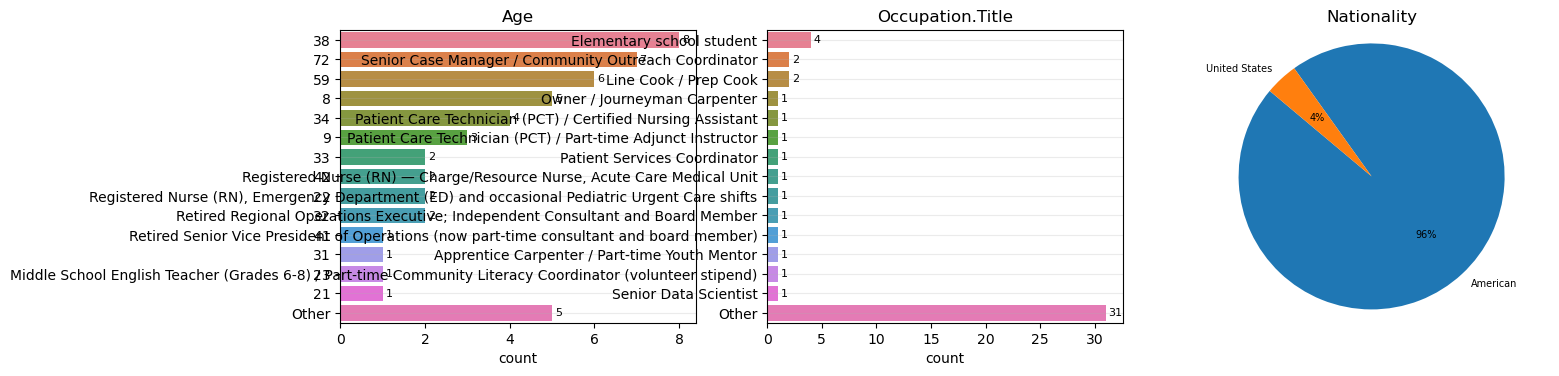

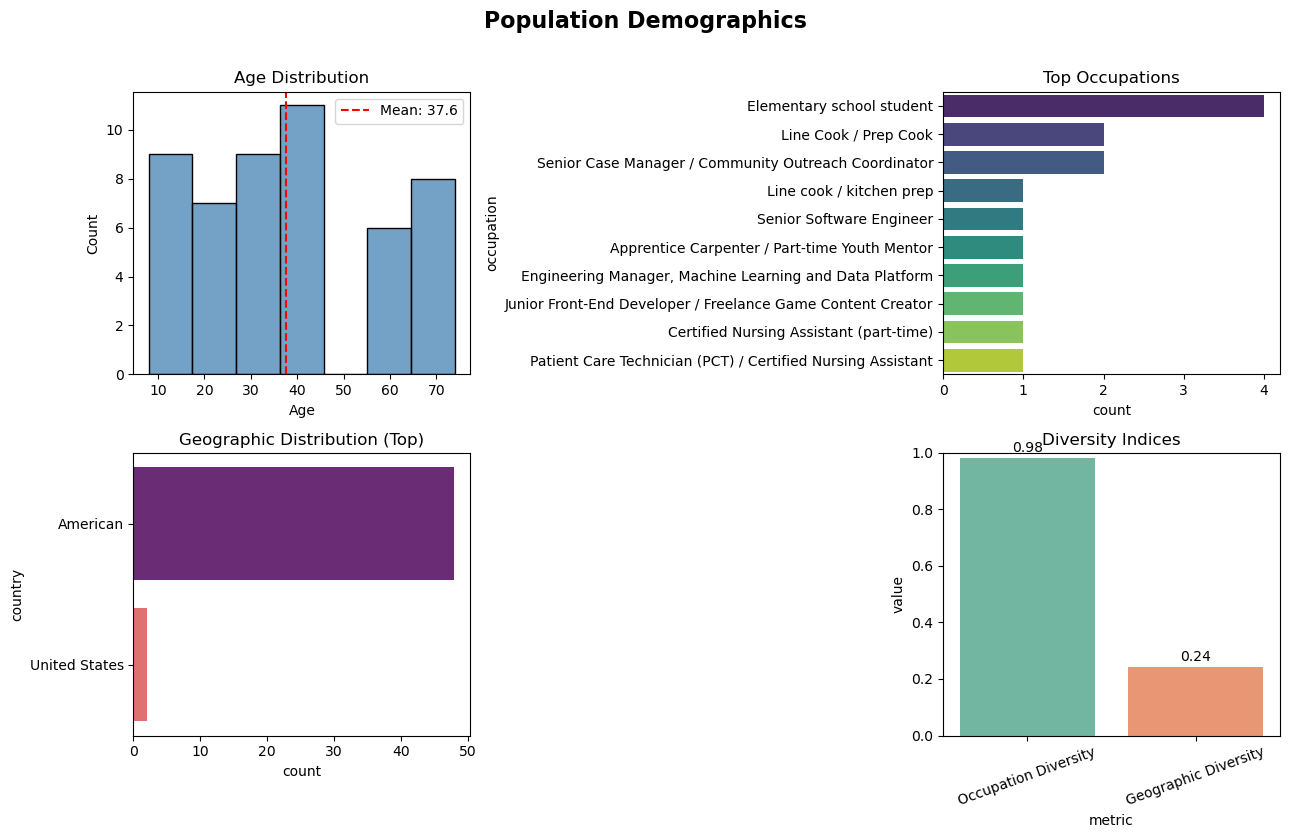

Persona composition keys found: ['interests', 'skills', 'beliefs', 'goals', 'likes_dislikes', 'routines', 'relationship_roles', 'communication_style', 'health', 'personality_traits']
[DEBUG persona_plot] facet 'interests' empty -> hidden
[DEBUG persona_plot] facet 'goals' empty -> hidden
[DEBUG persona_plot] facet 'likes_dislikes' empty -> hidden
[DEBUG persona_plot] facet 'relationship_roles' empty -> hidden
[DEBUG persona_plot] facet 'health' empty -> hidden


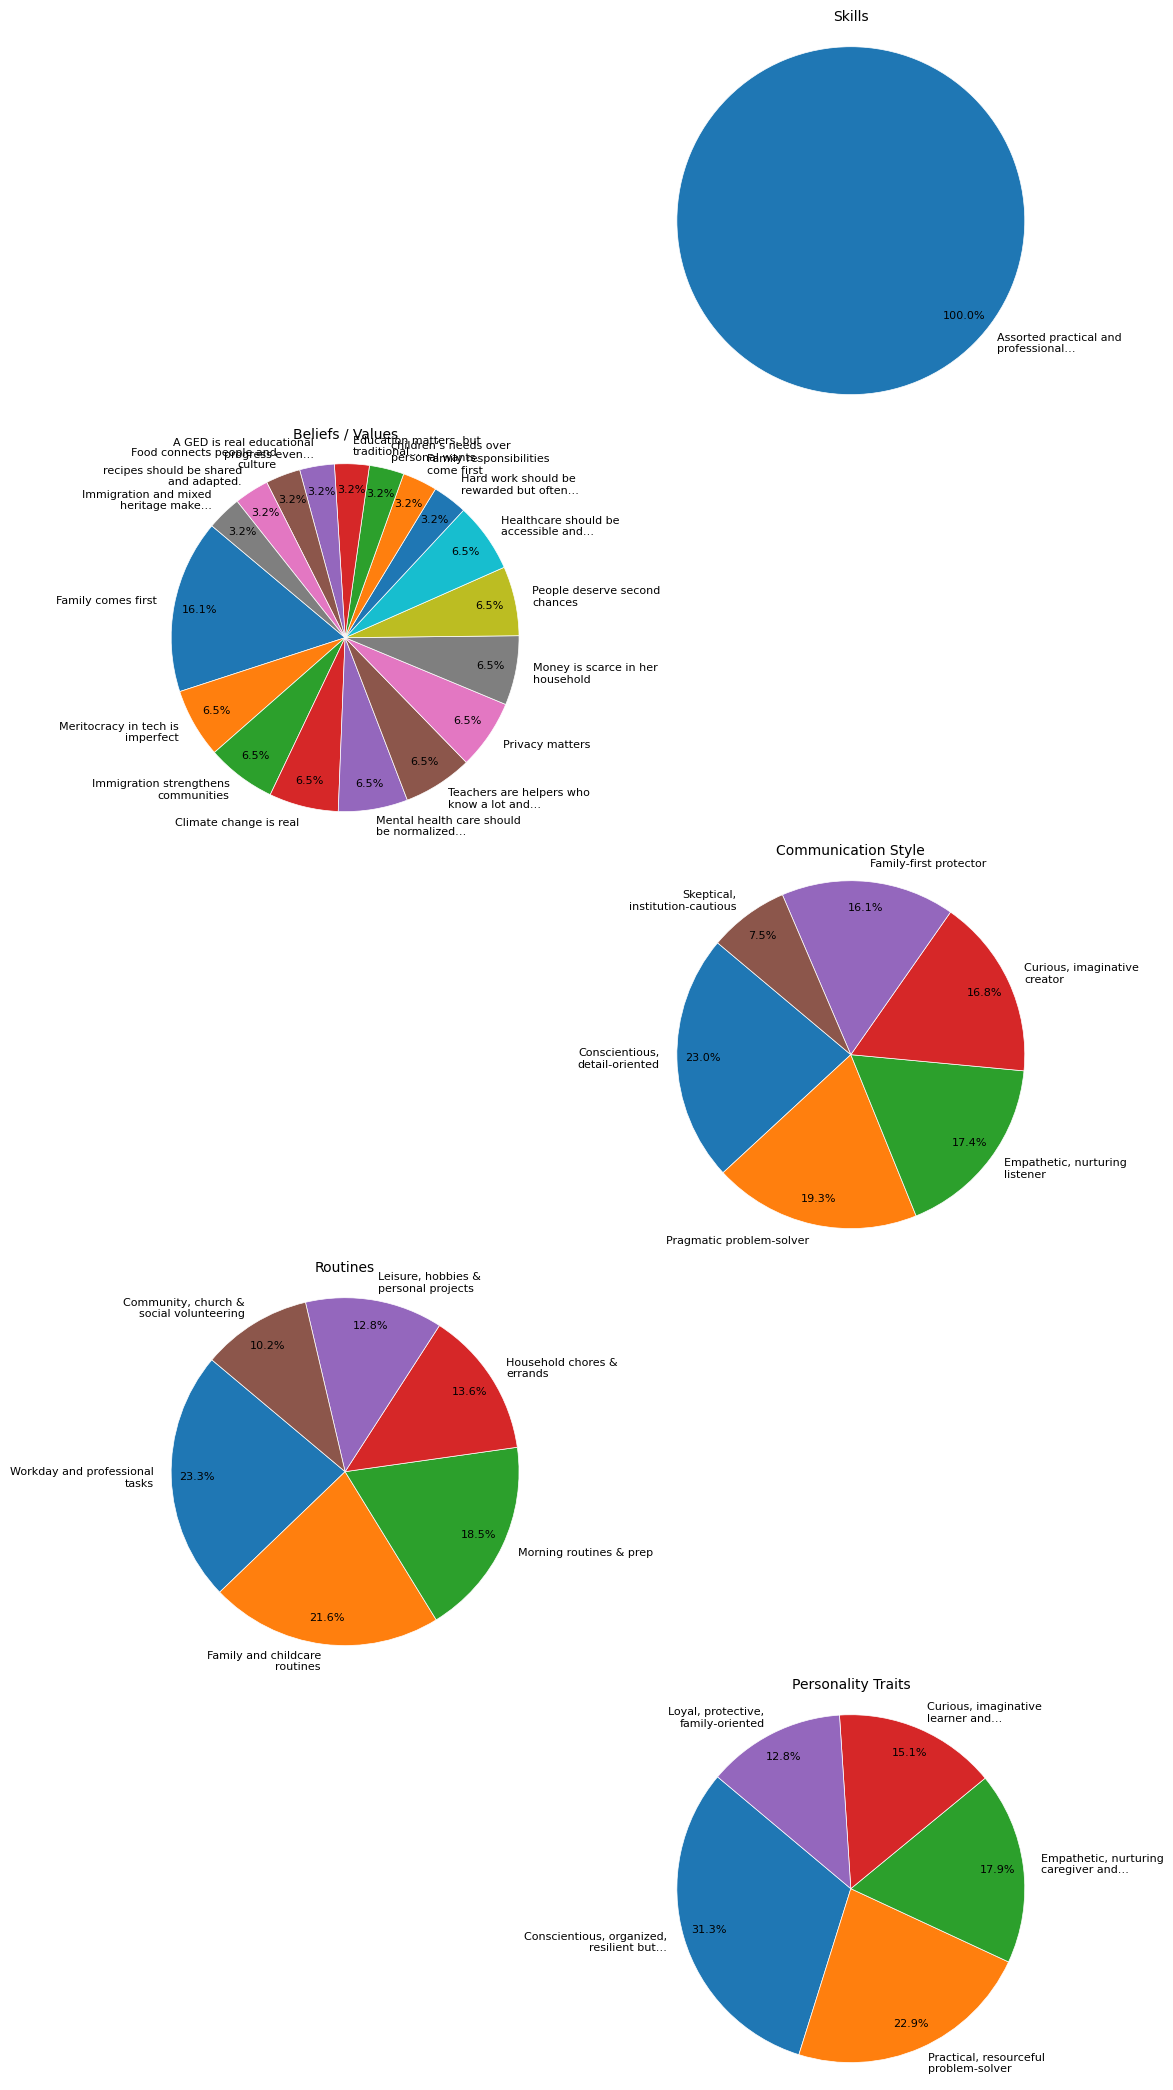

{'age': 8     5
 9     3
 10    1
 18    1
 19    1
 20    1
 21    1
 22    2
 23    1
 31    1
 32    2
 33    2
 34    4
 38    8
 41    1
 42    2
 59    6
 72    7
 74    1
 Name: count, dtype: int64,
 'occupation.title': Apprentice Carpenter / Part-time Youth Mentor                                                                    1
 Carpentry/Construction Worker and Part-time Youth Outreach Assistant                                             1
 Certified Nursing Assistant (CNA), retired/part-time                                                             1
 Certified Nursing Assistant (part-time / per-diem)                                                               1
 Certified Nursing Assistant (part-time)                                                                          1
 Certified Nursing Assistant (part-time) / Experienced Home Caregiver                                             1
 Community Caseworker / Outreach Counselor (part-time, nonprofit)             

In [14]:
profiler = Profiler()
profiler.profile(people)

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [15]:
#control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [16]:
market = TinyWorld(f"Target audience ({target_nationality})", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [17]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Jamal Hernandez: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Emily Chang-Bennett

       + --> Tanner Reid Olson

       + --> ...others...

USER --> Jamal Hernandez: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 1 to 5), where:        - 1: would
          > NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how
          > you feel, as it is part of the human experience.        - 2: very unlikely, but not
          > impossible.        - 3: maybe I would buy it, not sure.        - 4: it is very likely.
          > - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive
          > answer if it is how you feel, as it is part of the human experience.          Please
          > just give your number and justification, and then you are done. Giving a number helps us
          > compile the data, so use it please.

       + --> Emily Chang-Bennett

       + --> Tanner Reid Olson

       + --> ...others...

Jamal Hernandez --> Jamal Hernandez: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.      My answer will be something like "My
                     > propensity is X, because ...", always stating the propensity score and
                     > justifying it later.

Emily Chang-Bennett --> Emily Chang-Bennett: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.
                         > My answer will be something like "My propensity is X, because ...",
                         > always stating the propensity score and justifying it later.

Tanner Reid Olson --> Tanner Reid Olson: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests. I will not refrain from giving extreme
                       > answers,      such as 1 or 5, if that's how I really feel, as this exercise
                       > requires me to be honest, human and realistic.      Now I **must** first
                       > THINK deeply about the question, consider all the factors that might
                       > influence my decision,     and only then I will TALK with my response to
                       > the question as best, as detailed and as honestly as I can.      My answer
                       > will be something like "My propensity is X, because ...", always stating
                       > the propensity score and justifying it later.

Arjun Kiran Patel --> Arjun Kiran Patel: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests. I will not refrain from giving extreme
                       > answers,      such as 1 or 5, if that's how I really feel, as this exercise
                       > requires me to be honest, human and realistic.      Now I **must** first
                       > THINK deeply about the question, consider all the factors that might
                       > influence my decision,     and only then I will TALK with my response to
                       > the question as best, as detailed and as honestly as I can.      My answer
                       > will be something like "My propensity is X, because ...", always stating
                       > the propensity score and justifying it later.

Caleb Nathaniel Reed --> Caleb Nathaniel Reed: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Casey Nguyen --> Casey Nguyen: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                  > if that's how I really feel, as this exercise requires me to be honest, human
                  > and realistic.      Now I **must** first THINK deeply about the question,
                  > consider all the factors that might influence my decision,     and only then I
                  > will TALK with my response to the question as best, as detailed and as honestly
                  > as I can.      My answer will be something like "My propensity is X, because
                  > ...", always stating the propensity score and justifying it later.

Maria Elena Carter --> Maria Elena Carter: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Lauren Fitzgerald --> Lauren Fitzgerald: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests. I will not refrain from giving extreme
                       > answers,      such as 1 or 5, if that's how I really feel, as this exercise
                       > requires me to be honest, human and realistic.      Now I **must** first
                       > THINK deeply about the question, consider all the factors that might
                       > influence my decision,     and only then I will TALK with my response to
                       > the question as best, as detailed and as honestly as I can.      My answer
                       > will be something like "My propensity is X, because ...", always stating
                       > the propensity score and justifying it later.

Malachi James Redbird --> Malachi James Redbird: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Rebecca Anne Malone --> Rebecca Anne Malone: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.
                         > My answer will be something like "My propensity is X, because ...",
                         > always stating the propensity score and justifying it later.

Mariana Isabel Ramirez --> Mariana Isabel Ramirez: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.      My answer will be something like "My
                            > propensity is X, because ...", always stating the propensity score and
                            > justifying it later.

Kathleen Marie Hawthorne --> Kathleen Marie Hawthorne: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.      My answer will be something like "My
                              > propensity is X, because ...", always stating the propensity score
                              > and justifying it later.

Jordan Park-Sullivan --> Jordan Park-Sullivan: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

James Patrick Ellison --> James Patrick Ellison: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Claire Donovan --> Claire Donovan: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Owen Parker Bennett --> Owen Parker Bennett: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.
                         > My answer will be something like "My propensity is X, because ...",
                         > always stating the propensity score and justifying it later.

Erin Caroline Matthews --> Erin Caroline Matthews: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.      My answer will be something like "My
                            > propensity is X, because ...", always stating the propensity score and
                            > justifying it later.

Camila Rodriguez --> Camila Rodriguez: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests. I will not refrain from giving extreme answers,      such
                      > as 1 or 5, if that's how I really feel, as this exercise requires me to be
                      > honest, human and realistic.      Now I **must** first THINK deeply about
                      > the question, consider all the factors that might influence my decision,
                      > and only then I will TALK with my response to the question as best, as
                      > detailed and as honestly as I can.      My answer will be something like "My
                      > propensity is X, because ...", always stating the propensity score and
                      > justifying it later.

Dylan Marcus Anderson --> Dylan Marcus Anderson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Jalen Antonio Cruz --> Jalen Antonio Cruz: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Natalie Grace Porter --> Natalie Grace Porter: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Avery Chen-MacDonald --> Avery Chen-MacDonald: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Isabella Maria Martinez --> Isabella Maria Martinez: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.      My answer will be something like "My
                             > propensity is X, because ...", always stating the propensity score
                             > and justifying it later.

Bernice Carmen Martinez-Johnson --> Bernice Carmen Martinez-Johnson: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.      My answer will be
                                     > something like "My propensity is X, because ...", always
                                     > stating the propensity score and justifying it later.

Darnell Mateo Reyes --> Darnell Mateo Reyes: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.
                         > My answer will be something like "My propensity is X, because ...",
                         > always stating the propensity score and justifying it later.

Melissa Chen --> Melissa Chen: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                  > if that's how I really feel, as this exercise requires me to be honest, human
                  > and realistic.      Now I **must** first THINK deeply about the question,
                  > consider all the factors that might influence my decision,     and only then I
                  > will TALK with my response to the question as best, as detailed and as honestly
                  > as I can.      My answer will be something like "My propensity is X, because
                  > ...", always stating the propensity score and justifying it later.

Luis Alejandro Brown --> Luis Alejandro Brown: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

José Manuel Youngblood --> José Manuel Youngblood: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.      My answer will be something like "My
                            > propensity is X, because ...", always stating the propensity score and
                            > justifying it later.

Valentina Garcia --> Valentina Garcia: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests. I will not refrain from giving extreme answers,      such
                      > as 1 or 5, if that's how I really feel, as this exercise requires me to be
                      > honest, human and realistic.      Now I **must** first THINK deeply about
                      > the question, consider all the factors that might influence my decision,
                      > and only then I will TALK with my response to the question as best, as
                      > detailed and as honestly as I can.      My answer will be something like "My
                      > propensity is X, because ...", always stating the propensity score and
                      > justifying it later.

Laura Gallagher --> Laura Gallagher: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.      My answer will be something like "My
                     > propensity is X, because ...", always stating the propensity score and
                     > justifying it later.

Thomas Everett Sinclair --> Thomas Everett Sinclair: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.      My answer will be something like "My
                             > propensity is X, because ...", always stating the propensity score
                             > and justifying it later.

Sofía Morales --> Sofía Morales: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                   > if that's how I really feel, as this exercise requires me to be honest, human
                   > and realistic.      Now I **must** first THINK deeply about the question,
                   > consider all the factors that might influence my decision,     and only then I
                   > will TALK with my response to the question as best, as detailed and as honestly
                   > as I can.      My answer will be something like "My propensity is X, because
                   > ...", always stating the propensity score and justifying it later.

Christopher Grant Wallace --> Christopher Grant Wallace: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.      My
                               > answer will be something like "My propensity is X, because ...",
                               > always stating the propensity score and justifying it later.

Patricia Jeanette Walker --> Patricia Jeanette Walker: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.      My answer will be something like "My
                              > propensity is X, because ...", always stating the propensity score
                              > and justifying it later.

Maya Patel --> Maya Patel: [THOUGHT] 
                >      I will be honest as I understand they are not here to judge me, but just to
                > learn from me.      Such choices depend on many factors, but I will make my best
                > guess, considering my current      situation in life, location, job and interests.
                > I will not refrain from giving extreme answers,      such as 1 or 5, if that's how
                > I really feel, as this exercise requires me to be honest, human and realistic.
                > Now I **must** first THINK deeply about the question, consider all the factors
                > that might influence my decision,     and only then I will TALK with my response
                > to the question as best, as detailed and as honestly as I can.      My answer will
                > be something like "My propensity is X, because ...", always stating the propensity
                > score and justifying it later.

Sarah Whitmore --> Sarah Whitmore: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Rafael Yazzie --> Rafael Yazzie: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                   > if that's how I really feel, as this exercise requires me to be honest, human
                   > and realistic.      Now I **must** first THINK deeply about the question,
                   > consider all the factors that might influence my decision,     and only then I
                   > will TALK with my response to the question as best, as detailed and as honestly
                   > as I can.      My answer will be something like "My propensity is X, because
                   > ...", always stating the propensity score and justifying it later.

Gary Allen Miller --> Gary Allen Miller: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests. I will not refrain from giving extreme
                       > answers,      such as 1 or 5, if that's how I really feel, as this exercise
                       > requires me to be honest, human and realistic.      Now I **must** first
                       > THINK deeply about the question, consider all the factors that might
                       > influence my decision,     and only then I will TALK with my response to
                       > the question as best, as detailed and as honestly as I can.      My answer
                       > will be something like "My propensity is X, because ...", always stating
                       > the propensity score and justifying it later.

Malik Rivera --> Malik Rivera: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                  > if that's how I really feel, as this exercise requires me to be honest, human
                  > and realistic.      Now I **must** first THINK deeply about the question,
                  > consider all the factors that might influence my decision,     and only then I
                  > will TALK with my response to the question as best, as detailed and as honestly
                  > as I can.      My answer will be something like "My propensity is X, because
                  > ...", always stating the propensity score and justifying it later.

Ethel Mae Washington --> Ethel Mae Washington: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Luke Bauer --> Luke Bauer: [THOUGHT] 
                >      I will be honest as I understand they are not here to judge me, but just to
                > learn from me.      Such choices depend on many factors, but I will make my best
                > guess, considering my current      situation in life, location, job and interests.
                > I will not refrain from giving extreme answers,      such as 1 or 5, if that's how
                > I really feel, as this exercise requires me to be honest, human and realistic.
                > Now I **must** first THINK deeply about the question, consider all the factors
                > that might influence my decision,     and only then I will TALK with my response
                > to the question as best, as detailed and as honestly as I can.      My answer will
                > be something like "My propensity is X, because ...", always stating the propensity
                > score and justifying it later.

Adrian Lee --> Adrian Lee: [THOUGHT] 
                >      I will be honest as I understand they are not here to judge me, but just to
                > learn from me.      Such choices depend on many factors, but I will make my best
                > guess, considering my current      situation in life, location, job and interests.
                > I will not refrain from giving extreme answers,      such as 1 or 5, if that's how
                > I really feel, as this exercise requires me to be honest, human and realistic.
                > Now I **must** first THINK deeply about the question, consider all the factors
                > that might influence my decision,     and only then I will TALK with my response
                > to the question as best, as detailed and as honestly as I can.      My answer will
                > be something like "My propensity is X, because ...", always stating the propensity
                > score and justifying it later.

Diane Montgomery --> Diane Montgomery: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests. I will not refrain from giving extreme answers,      such
                      > as 1 or 5, if that's how I really feel, as this exercise requires me to be
                      > honest, human and realistic.      Now I **must** first THINK deeply about
                      > the question, consider all the factors that might influence my decision,
                      > and only then I will TALK with my response to the question as best, as
                      > detailed and as honestly as I can.      My answer will be something like "My
                      > propensity is X, because ...", always stating the propensity score and
                      > justifying it later.

Ethan Nakamura --> Ethan Nakamura: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Rafael Miguel Jackson --> Rafael Miguel Jackson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Benjamin Cooper --> Benjamin Cooper: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.      My answer will be something like "My
                     > propensity is X, because ...", always stating the propensity score and
                     > justifying it later.

Jason Thompson --> Jason Thompson: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Evelyn Cruz --> Evelyn Cruz: [THOUGHT] 
                 >      I will be honest as I understand they are not here to judge me, but just to
                 > learn from me.      Such choices depend on many factors, but I will make my best
                 > guess, considering my current      situation in life, location, job and
                 > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                 > if that's how I really feel, as this exercise requires me to be honest, human and
                 > realistic.      Now I **must** first THINK deeply about the question, consider
                 > all the factors that might influence my decision,     and only then I will TALK
                 > with my response to the question as best, as detailed and as honestly as I can.
                 > My answer will be something like "My propensity is X, because ...", always
                 > stating the propensity score and justifying it later.

Hannah Park-Wilson --> Hannah Park-Wilson: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Angela Harris --> Angela Harris: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                   > if that's how I really feel, as this exercise requires me to be honest, human
                   > and realistic.      Now I **must** first THINK deeply about the question,
                   > consider all the factors that might influence my decision,     and only then I
                   > will TALK with my response to the question as best, as detailed and as honestly
                   > as I can.      My answer will be something like "My propensity is X, because
                   > ...", always stating the propensity score and justifying it later.

In [18]:
market.run(1)

2025-10-02 14:37:48,258 - tinytroupe - INFO - [Target audience (American)] Running world simulation step 1 of 1.


───────────────────────────────────── Target audience (American) step 1 of 1 ──────────────────────────────────────

2025-10-02 14:37:48,262 - tinytroupe - INFO - [Target audience (American)] No timedelta provided, so the datetime was not advanced.
2025-10-02 14:38:09,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:38:09,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:38:10,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:38:13,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:38:13,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:38:15,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:38:16,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:38:17,9

Maria Elena Carter acts: [THINK] 
                        > I need to be honest and practical. Considerations: my tastes (I like
                        > familiar, home-cooked foods; cold soups are not a regular part of my
                        > meals), my health (hypertension and diabetes — watch salt and added
                        > sugars), convenience (I buy ready meals when I'm tired after a shift),
                        > price and trust in brands (I stick with brands I know or recommendations
                        > from family/church), seasonality (a cold soup would be nicer in hot
                        > weather), and portion size (I'd prefer a small bottle to try). Also
                        > remember: I'm hesitant about new packaged products unless someone I trust
                        > recommends them. Weighing these, I should give a cautious but open answer.

Maria Elena Carter acts: [TALK] 
                        > My propensity is 3, because I might buy it sometimes but only under a few
                        > conditions. I like the idea of something light and ready on a hot day, and
                        > a bottled gazpacho could be a quick, healthy snack if it tastes fresh. But
                        > I worry about sodium and any added sugar — with my blood pressure and
                        > diabetes I have to be careful. I also tend to stick with brands I know, so
                        > I'd try a small bottle first or buy it if somebody I trust recommends it.
                        > If it were low-sodium, not too expensive, and sold in my corner store, I
                        > would be willing to give it a try. Otherwise, probably not.

Maria Elena Carter acts: [DONE] 
                        > Finished my answer to the gazpacho question.

2025-10-02 14:39:07,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:10,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:11,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Mariana Isabel Ramirez acts: [THINK] 
                            > I need to think first. I like quesadillas, mango y pan dulce. I do NOT
                            > like vegetables plain and cold soups make me say 'yuck' a little.
                            > Gazpacho is a cold tomato-cucumber-pepper soup. Also my mamá buys
                            > things that are familiar and not expensive. If it smelled like salsa
                            > or had mango maybe I'd try it, but right now I'm not sure. I will pick
                            > a number and explain why.

Mariana Isabel Ramirez acts: [TALK] 
                            > My propensity is 2, porque muy poco probable que lo compre. No me
                            > gusta la idea de una sopa fría de verduras and at home we eat warm
                            > food like quesadillas. Also my mamá picks things that she knows and
                            > that are cheap. Maybe if it tasted like tomato salsa or had mango
                            > flavor I'd try it (then maybe 3), but now it sounds a little weird to
                            > me, so 2.

Mariana Isabel Ramirez acts: [DONE] 
                            > Finished answering the gazpacho question.

2025-10-02 14:39:12,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Casey Nguyen acts: [THINK] 
                  > Okay — think through this honestly like I promised. Factors that matter to me:
                  > 1) Taste/profile: I like savory, well-seasoned food (rice bowls, bánh mì,
                  > dumplings). Gazpacho is a cold, vegetal Spanish soup — I’m open to savory cold
                  > things but it needs good seasoning so it doesn’t taste bland or watery. 2)
                  > Freshness/processing: Bottled soups often taste overly processed. If it
                  > smells/feels fresh and has clean ingredients, I’m more likely to try it;
                  > preservatives or weird aftertastes are a turn-off. 3) Convenience & timing: I
                  > commute and sometimes grab ready-to-eat items. A bottled gazpacho could work as
                  > a light lunch or summer snack on the T, so convenience increases propensity. 4)
                  > Price & value: I’m budget-conscious (junior dev + freelance), so price matters —
                  > I’d buy occasionally if it’s reasonably priced, not premium-priced for a small
                  > bottle. 5) Seasonality: I’d be more likely to buy it in warm months when a cold,
                  > refreshing option is appealing. 6) Packaging & sustainability: I care about
                  > packaging (recycl (...)

Casey Nguyen acts: [TALK] 
                  > My propensity is 3. I’d maybe buy a ready-to-drink bottled gazpacho — I’m
                  > curious and would try it once or occasionally (especially in summer or as a
                  > convenient lunch), but I wouldn’t commit to buying it regularly unless it tasted
                  > fresh, was well-seasoned, had a clean ingredient list, and was reasonably
                  > priced. Packaging that’s recyclable would help, too.

Casey Nguyen acts: [DONE] 
                  > Finished — answered the gazpacho propensity question.

2025-10-02 14:39:14,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:14,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Jamal Hernandez acts: [THINK] 
                     > Okay — gotta be straight. Think through the gazpacho question: do I, Jamal,
                     > buy ready-to-drink cold tomato-cucumber soup from the supermarket? Factors:
                     > taste (I'm more into hot, salty, spicy comfort food), temperature (I work
                     > late nights and usually want something warm), price (tight budget), my
                     > daughter (she wouldn't eat it), occasions (maybe on a real hot day it'd make
                     > sense), and familiarity (not a regular for me). Also consider convenience —
                     > bottled is easy — but value has to beat reheating leftovers or a cheap
                     > takeout. Leaning toward unlikely. I'll say the number and explain why, and
                     > mention what would make me change my mind.

Jamal Hernandez acts: [TALK] 
                     > My propensity is 2 — very unlikely. Reason: I just don't see myself reaching
                     > for a cold, blended veggie soup on a regular basis. I prefer hot, filling
                     > stuff (tacos, grilled things, reheated leftovers) and I'm careful with money,
                     > so a ready-made bottle has to feel worth it. My kid wouldn't want it, and
                     > most days after a night shift I want something warm and quick. Maybe on a
                     > real hot summer day or if it was cheap and had a spicy kick or familiar
                     > flavors (like a tangy, peppery version), I'd consider it — that might push me
                     > to a 3. As it stands, 2. That's my honest take.

Jamal Hernandez acts: [DONE] 
                     > Answered the gazpacho propensity question.

2025-10-02 14:39:14,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Tanner Reid Olson acts: [THINK] 
                       > Okay — thinkin' this through. I like tomatoes and made jars of salsa last
                       > summer, so the base ingredients ain't a turn-off. Thing is, I usually bring
                       > a sandwich or burrito to work and don't eat cold soup on a regular day.
                       > Bottled stuff needs to taste honest (not too sweet or fancy), be cheap, and
                       > be useful in summer after a hot job. If it's pricey or feels gimmicky, I
                       > won't bother. I'll give a single number and explain.

Tanner Reid Olson acts: [TALK] 
                       > My propensity is 3, because I like tomatoes and the idea of a ready cold
                       > soup on a hot day, but I prefer homemade salsa/gazpacho and am price-
                       > conscious. I'd buy it sometimes in summer if it tastes like real vegetables
                       > (not too sweet or salty) and isn't expensive. In cooler months or if it's
                       > overpriced/pretentious, I probably wouldn't.

Tanner Reid Olson acts: [DONE] 
                       > Answered the market-research question honestly.

2025-10-02 14:39:17,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:17,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Emily Chang-Bennett acts: [THINK] 
                         > Okay — walk through this pragmatically. Factors that matter to me: (1)
                         > freshness/texture (gazpacho should taste bright, not watered-down); (2)
                         > ingredient list — short and recognizable; (3) refrigeration vs shelf-
                         > stable (I prefer refrigerated for a fresh-soup vibe); (4) convenience —
                         > good for solo lunches or a park picnic; (5) kid acceptance — Maya and Eli
                         > probably won't be fans, so it won't be a family staple; (6) price and
                         > packaging (recyclable or low-waste preferred); (7) seasonal use — more
                         > appealing in summer. Given I shop farmers' markets and like simple, high-
                         > quality ingredients, I'd try a well-made refrigerated bottled gazpacho
                         > once or twice in season but wouldn't buy it regularly unless it met
                         > freshness/ingredient and price expectations. That points to a middle
                         > score.

Emily Chang-Bennett acts: [TALK] 
                         > My propensity is 3, because I like the idea but would be conditional. I’d
                         > consider buying ready-to-drink gazpacho for a convenient, light summer
                         > lunch or a picnic if it’s refrigerated, has a short/clean ingredient list
                         > (tomato, cucumber, pepper, olive oil, vinegar, salt), and is reasonably
                         > priced. I’m skeptical of shelf-stable, overly processed versions — they
                         > often lose the bright, fresh flavor that makes gazpacho appealing. It
                         > wouldn’t be a regular family buy (the kids would likely reject it), but
                         > I’d try a good local brand once or twice in the season. If it were widely
                         > available in recyclable packaging and tasted fresh, I’d move toward a 4
                         > over time.

Emily Chang-Bennett acts: [DONE] 
                         > Finished response — waiting for next question.

2025-10-02 14:39:17,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Caleb Nathaniel Reed acts: [THINK] 
                          > Okay, I need to think first like I said. Things to consider: I'm nine
                          > and I don't like vegetables plain, and gazpacho is mostly blended
                          > vegetables and cold. My mom and dad usually buy snacks and drinks for
                          > the house, not me alone, so they'd decide if we try it. In summer a cold
                          > soup might sound okay, but I usually pick fruit drinks or chocolate
                          > milk. If it tasted more like tomato juice with spices I might try a
                          > small bottle. Also price and how it looks on the shelf would matter. I
                          > should be honest and pick a number that fits how likely I'd ask my
                          > parents to buy it.

Caleb Nathaniel Reed acts: [TALK] 
                          > My propensity is 2, because I very likely wouldn't ask my parents to buy
                          > a ready-to-drink gazpacho. It sounds like a cold, plain vegetable soup
                          > and I don't like vegetables served plain. Maybe I'd try a tiny bottle
                          > once in summer if it looked fun or my parents said yes, but usually I'd
                          > pick something sweeter or a fruit drink instead.

Caleb Nathaniel Reed acts: [DONE] 
                          > Finished answer; waiting for next question.

2025-10-02 14:39:18,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Kathleen Marie Hawthorne acts: [THINK] 
                              > Consider factors that influence whether I'd purchase bottled
                              > gazpacho: my taste for Italian/Spanish regional food, preference for
                              > fresh market produce, habit of shopping at Whole Foods and farmers'
                              > markets, concern about preservatives and refrigeration, price
                              > sensitivity for prepared foods in retirement budget, occasions when
                              > convenience wins (hot summer days, picnics), and trust in
                              > provenance/brand. I should give a single numeric propensity and
                              > justify it succinctly in my own voice.

Kathleen Marie Hawthorne acts: [TALK] 
                              > My propensity is 3. I like the idea — I enjoy the flavors of
                              > gazpacho and appreciate chilled, vegetable-forward preparations on a
                              > warm day — but I am cautious about ready-to-drink versions. I would
                              > consider buying a bottled gazpacho if it met a few conditions: sold
                              > refrigerated (not a shelf-stable syrup), made with high-quality,
                              > simple ingredients and minimal preservatives, clearly labeled
                              > provenance (local or small-batch preferred), a reasonable single-
                              > serving or sharing-size price at a store I trust (Whole Foods or a
                              > good independent market), and ideally available to sample first. If
                              > those boxes are checked, I might buy it occasionally for a picnic or
                              > a quick, elegant lunch; otherwise I’d stick with a market-made batch
                              > or a restaurant version.

Kathleen Marie Hawthorne acts: [DONE] 
                              > Finished — awaiting any follow-up questions.

2025-10-02 14:39:26,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Lauren Fitzgerald acts: [THINK] 
                       > Okay — weigh the factors. I like Mediterranean flavors and roasted veggies,
                       > so the idea of gazpacho appeals to me in principle. Practical
                       > considerations matter: will I buy something my kids will drink/eat?
                       > Probably not for them, so purchases would be for me or as a light lunch
                       > option. Convenience on busy shifts or a hot weekend makes single-serve
                       > bottled soups attractive, but price has to be reasonable and ingredients
                       > should look fresh (low sodium, no weird preservatives). I also prefer
                       > supporting local vendors (farmers' market) but a supermarket option that
                       > mirrors that fresh taste and uses decent packaging could work. Seasonality
                       > matters — more likely in summer. On a 1–5 scale, these push me toward a
                       > neutral 'maybe' unless the product is clearly fresh-tasting, affordable,
                       > and in a recyclable single-serve size. I'll state the number and then
                       > justify.

Lauren Fitzgerald acts: [TALK] 
                       > My propensity is 3 — maybe I would buy it. Reason: I like Mediterranean-
                       > style, vegetable-forward foods, so gazpacho sounds appealing as a light,
                       > convenient option for a hot day or a quick lunch on shift. However, a few
                       > things would determine an actual purchase: the ingredient list (short and
                       > fresh-looking is a must), portion/price (single-serve under about $4 would
                       > help), and seasonality (I'd buy more in summer). Downsides: my kids
                       > probably won't eat it, so it would be a single-adult purchase; I might
                       > prefer fresh vendor-made gazpacho at the farmers' market if it's available
                       > and similarly priced. If the bottled version tastes fresh, isn't too salty,
                       > and comes in a recyclable container, I'd be more likely to move this to a
                       > 4.

Lauren Fitzgerald acts: [DONE] 
                       > Finished — answered the gazpacho question honestly.

2025-10-02 14:39:31,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Arjun Kiran Patel acts: [THINK] 
                       > Consider factors before answering: my culinary preferences (lean toward
                       > fresh, whole-food Mediterranean/Indian preparations), seasonality (cold
                       > soup appeals more in hot months), convenience needs (quick lunches or
                       > picnic items), ingredient/processing concerns (I prefer minimal
                       > preservatives, reasonable sodium), packaging preference (refrigerated,
                       > preferably glass or clearly labeled), and household context (I shop for two
                       > adults and a toddler; would buy items primarily for adults). Balance
                       > willingness to try new supermarket items against a habit of preferring
                       > locally-made or freshly prepared options. I should give a single propensity
                       > score and justify it succinctly.

Arjun Kiran Patel acts: [TALK] 
                       > My propensity is 3, because I like the flavours in a traditional gazpacho
                       > and can see it working as a light, convenient lunch or picnic item in warm
                       > months, but I generally prefer fresh or locally made versions. I would be
                       > willing to try a bottled, ready-to-drink gazpacho if it was refrigerated,
                       > had a short/transparent ingredient list (no weird stabilizers or excessive
                       > salt), and was reasonably priced. If it tasted overly processed or was
                       > shelf-stable with a long ingredient list, I  be unlikely to buy it
                       > regularly. So: occasional purchase (summer or convenience situations), not
                       > a staple.

Arjun Kiran Patel acts: [DONE] 
                       > Finished answering the gazpacho propensity question; waiting for any
                       > follow-ups.

2025-10-02 14:39:31,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Malachi James Redbird acts: [THINK] 
                           > I gotta be honest. Thinkin' 'bout money first — we don't buy fancy
                           > bottled food much. Mama cooks most things at home and I like warm fish
                           > and cornbread more. Gazpacho is a cold tomato-cucumber-pepper soup.
                           > That sounds odd to me, but on a hot day it might be nice. Also I don't
                           > know if it would taste like Nana's real food. If it was cheap or they
                           > gave a sample, maybe we'd try it once. So I'm leaning toward not buyin'
                           > it regular-like, but maybe once if it seemed good.

Malachi James Redbird acts: [TALK] 
                           > My propensity is 2, because my family watches how we spend money and we
                           > usually pick home-cooked meals over bottled stuff. Gazpacho sounds like
                           > a cold tomato and veg soup — I might try it on a hot day, but I
                           > wouldn't buy it often. If it was cheap, had a small price, or my mom
                           > liked the taste after a sample, we might buy one once in a while.
                           > Otherwise it's not somethin' we'd pick instead of our usual foods.

Malachi James Redbird acts: [DONE] 
                           > Finished answering the gazpacho question.

2025-10-02 14:39:34,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:34,948 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:40,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:41,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:41,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:42,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:43,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:44,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Rebecca Anne Malone acts: [THINK] 
                         > Okay — I'll weigh the practical factors before I answer: taste/texture (I
                         > like fresh, tomato-forward flavors), seasonality (cold soup is more
                         > appealing in summer), convenience (single-serve bottles are handy on a
                         > busy shift), price (we watch the budget), ingredient list (I avoid weird
                         > preservatives and high sodium), and whether my kids would accept it. I
                         > shop at Trader Joe's and local markets and tend to prefer locally made or
                         > simple-ingredient foods. If a bottled gazpacho tastes fresh, is
                         > reasonably priced, and has a clean label (or comes from a local vendor),
                         > I'm likely to try it; if it tastes processed, is expensive, or is full of
                         > salt/preservatives, I won't buy it again. On balance I think a cautious,
                         > conditional answer fits best.

Rebecca Anne Malone acts: [TALK] 
                         > My propensity is 3. I might buy ready-to-drink bottled gazpacho
                         > occasionally — especially in warm months or as a quick, light lunch — but
                         > it depends. I'd want simple, fresh ingredients (not a bunch of
                         > preservatives), reasonable price or single-serve sizing, and a flavor my
                         > family will accept. If it were locally made or sold at Trader
                         > Joe's/farmers' market with a clean label, I'd be more likely to pick it
                         > up more often.

Rebecca Anne Malone acts: [DONE] 
                         > Finished survey response.

2025-10-02 14:39:45,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:54,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:55,492 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:39:57,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:10,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:19,721 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:24,702 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:29,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:31,178 - httpx 

Claire Donovan acts: [THINK] 
                    > I should be honest and practical here. Factors that matter for me: taste and
                    > freshness (I prefer fresh, minimally processed foods), ingredient list (low
                    > added sugar/sodium), packaging (I'd prefer glass or recyclable), price (as a
                    > busy teacher with a family, $3–6 single-serve is reasonable), and seasonality
                    > (gazpacho feels like a summer item). I also weigh convenience against my habit
                    > of making soups from scratch or buying from farmers' market vendors I trust.
                    > If a bottled gazpacho is clearly high-quality, locally sourced or from a
                    > trusted small producer, and kept refrigerated, I'm much more likely to try it.
                    > If it's overly processed, shelf-stable with preservatives, or overpriced, I
                    > won't. Given those trade-offs and my typical shopping habits, I think my
                    > answer should be cautious but open.

Claire Donovan acts: [TALK] 
                    > My propensity is 3: maybe I would buy it, not sure. I like the idea for hot
                    > summer lunches or picnics and I appreciate convenient, healthy options — but
                    > I'd only buy a ready-to-drink gazpacho if the ingredient list looked fresh
                    > (real tomatoes, cucumbers, peppers, olive oil), sodium and added sugar were
                    > low, it was refrigerated or in a glass bottle (less plastic), and the price
                    > felt fair. I’d prefer a local producer or a transparent brand story; otherwise
                    > I’d rather make a batch at home or buy from a farmers' market vendor. So I’m
                    > open but conditional.

Claire Donovan acts: [DONE] 
                    > Finished my response.

2025-10-02 14:40:34,689 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:35,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:36,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:42,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Dylan Marcus Anderson acts: [THINK] 
                           > Alright — gotta walk through this. What matters to me: taste (I like
                           > hearty, filling food, not fancy cold soups), convenience (if it's easy
                           > and cheap I might try), weather (on a real hot day a cold soup could be
                           > alright), price (I watch costs), who else likes it (Emma or the teens
                           > might eat it), and how it's marketed (local, simple packaging might
                           > help). Overall my gut says this isn't a regular thing for me: not
                           > enough calories for a work lunch, texture and flavor are a bit weird
                           > compared to what I usually eat, but I might try one on a hot day or if
                           > someone else buys it first. So leaning unlikely but not absolute no.

Dylan Marcus Anderson acts: [TALK] 
                           > My propensity is 2 — very unlikely. I don't see myself buying bottled
                           > gazpacho regularly. I'm usually lookin' for something filling to take
                           > to the jobsite (sandwiches, jerky, coffee), and a cold blended
                           > vegetable soup doesn't fit that. If it was cheap, on sale, or Emma/one
                           > of the teens liked it, I'd try one once on a hot afternoon, but I
                           > wouldn't make it a regular item on my grocery list. Also, around here
                           > folks prefer familiar, simple foods — unless it was sold as a local,
                           > no-nonsense product, it feels a bit too fancy and not worth the money
                           > for me.

Dylan Marcus Anderson acts: [DONE] 
                           > Answered the gazpacho propensity question.

2025-10-02 14:40:45,404 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


James Patrick Ellison acts: [THINK] 
                           > Acknowledge the internal prompt to be honest. Consider factors that
                           > will influence my decision: personal taste (I like ripe summer tomatoes
                           > and simple cold preparations), seasonality (I'd favor this in late
                           > spring/summer), provenance and ingredient quality (I prefer real,
                           > minimally processed ingredients), packaging and refrigeration (must be
                           > refrigerated and not overly sweet or watery), convenience and price
                           > (acceptable as an occasional premium convenience item), and health
                           > considerations (reasonable sodium/fat). Weighing those, I'm leaning
                           > positive but conditional on quality and provenance. I'll state a
                           > numeric propensity and a succinct justification.

James Patrick Ellison acts: [TALK] 
                           > My propensity is 4. I like the idea of a ready-to-drink bottled
                           > gazpacho as a seasonal, convenient option—especially in late spring and
                           > summer—because it fits my preference for fresh tomato-forward dishes (I
                           > love a good summer tomato salad). I'd buy it occasionally if it's
                           > refrigerated, made with real ingredients (no heavy preservatives or
                           > excess sugar), and comes from a producer with clear provenance (local
                           > or small-batch preferred). I wouldn't buy it if it tastes overly
                           > processed, is shelf-stable with a compromised flavor, or is priced like
                           > a specialty meal replacement. In short: likely to buy, provided the
                           > product meets those quality conditions.

James Patrick Ellison acts: [DONE] 
                           > Finished response; waiting for next stimulus.

2025-10-02 14:40:45,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:48,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:50,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:40:50,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Jordan Park-Sullivan acts: [THINK] 
                          > Okay — be honest and practical. Factors that matter to me: convenience
                          > (I work long days and value quick lunches), seasonality (gazpacho feels
                          > very summer-y), freshness/texture concerns (bottled soups can taste flat
                          > or overly processed), ingredient transparency (I care if it’s real
                          > tomatoes/cucumber/peppers and low on weird preservatives), price (I
                          > won’t pay premium for something that tastes like cardboard), and
                          > supporting local makers (I prefer small vendors but will buy supermarket
                          > items for convenience). Also: I eat out a few times a week and like
                          > small authentic places, so a bottled gazpacho would be an occasional
                          > convenience buy, not a staple. If it’s well-priced, clearly fresh, and
                          > marketed as a local/clean label, I’d try it once and maybe rebuy in
                          > summer. Otherwise I’d pass. Conclusion forming: this is a maybe —
                          > leaning neutral.

Owen Parker Bennett acts: [THINK] 
                         > Okay, I need to answer honestly. I like pizza and smoothies, but I don't
                         > like cold tomato-y veggie drinks. Also I'm 10 so I don't usually buy
                         > groceries myself — my parents do. I'll pick a number and explain why.

Owen Parker Bennett acts: [TALK] 
                         > My propensity is 1, because I would NEVER buy bottled gazpacho. It sounds
                         > like a cold, blended tomato-and-vegetable soup and that seems gross to
                         > me. I prefer sweet or familiar snacks, and new savory veggie drinks
                         > aren't my thing. Maybe my parents would try it, but I wouldn't pick it
                         > for myself, you know.

Jordan Park-Sullivan acts: [TALK] 
                          > My propensity is 3, because I think it’s a solid maybe. I like the idea
                          > of a ready-to-drink gazpacho as a light, grab-and-go lunch option in
                          > summer, but I’m cautious about bottled versions tasting processed or
                          > bland. I’d try it if it was clearly fresh/clean-ingredient labeled,
                          > chilled, and reasonably priced — otherwise I’d probably stick to getting
                          > it from a small cafe or making a quick batch at home. So not a hard yes
                          > or no, just a cautious one-time try with potential to become a seasonal
                          > pick.

Owen Parker Bennett acts: [DONE] 
                         > Finished answer; waiting for the next question.

Jordan Park-Sullivan acts: [DONE] 
                          > Finished answering the gazpacho question.

2025-10-02 14:40:52,924 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Erin Caroline Matthews acts: [THINK] 
                            > Okay — think it through like I would at the kitchen counter while
                            > packing lunches. Factors to weigh:  1) Personal taste and curiosity: I
                            > like trying foods from other cultures and new prepared items at the
                            > grocery. Gazpacho is a familiar concept (cold blended veg soup) and I
                            > enjoy tomato-forward, fresh flavors. That leans toward trying it.  2)
                            > Family acceptance: I have two kids (9 and 6) who can be picky. A
                            > chilled vegetable soup is not an everyday kid-favorite, so buying a
                            > bottle for the pantry risks waste unless Marcus or I will eat it or
                            > it's kid-friendly.  3) Seasonality and usage: Gazpacho makes more
                            > sense in warm months or as a light lunch/snack. In summer I’d be more
                            > likely to purchase once or twice; in winter, much less.  4) Quality
                            > and ingredients: I’m cautious about processed/pre-bottled items — I
                            > check ingredients, sodium, preservatives, and prefer things that list
                            > simple produce, good olive oil, and no unnecessary additives. If it
                            > tastes fresh or comes from a trusted local brand, that increases my
                            > (...)

Erin Caroline Matthews acts: [TALK] 
                            > My propensity is 3, because I’m curious and would maybe buy ready-to-
                            > drink bottled gazpacho — especially in warm months or if it’s a
                            > local/clean-ingredient brand at a fair price — but I’d hesitate if it
                            > looked overly processed, pricey, or if I thought it would go uneaten
                            > by the kids. If it were on sale and small enough to sample, I’d
                            > probably give it a try.

Erin Caroline Matthews acts: [DONE] 
                            > Finished — answered the market-research question honestly.

2025-10-02 14:40:53,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Avery Chen-MacDonald acts: [THINK] 
                          > Okay — weigh the real factors: my taste habits (I like savory, slightly
                          > spicy stuff; cold soups aren't a regular go-to), seasonality (more
                          > appealing in summer), convenience vs. freshness (I usually prefer fresh
                          > at a cafe but bottled wins on busy days), ingredient transparency and
                          > sodium/preservatives (important to me), price sensitivity (on a budget),
                          > and packaging/recycling. Decide a single propensity number and justify
                          > it honestly.

Avery Chen-MacDonald acts: [TALK] 
                          > My propensity is 3, because I might buy a ready-to-drink bottled
                          > gazpacho sometimes but not regularly. I’d try it as a convenient,
                          > refreshing lunch on a hot day if it tasted fresh, was clearly labeled
                          > (low sodium, no weird preservatives), came in recyclable packaging, and
                          > was reasonably priced (~$3–$5). Otherwise I’d default to a cafe or
                          > homemade option. So: maybe — I’ll buy it occasionally if it meets those
                          > criteria.

Avery Chen-MacDonald acts: [DONE] 
                          > Finished answering the gazpacho propensity question.

2025-10-02 14:40:57,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:00,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Camila Rodriguez acts: [THINK] 
                      > I need to decide my number and explain why. Think about what I like: I love
                      > popsicles and mango, and I don't like bitter vegetables. Gazpacho is a cold
                      > tomato-cucumber soup — sounds savory and grown-up. Also my family watches
                      > money and my mamá buys what we usually eat. If it was sweet or like a snack
                      > I would try, but a bottled cold vegetable soup feels strange. I might taste
                      > it one time if mamá says it's okay or if it is cheap, but I probably
                      > wouldn't pick it by myself at the store. So I think my answer will be a low
                      > number. I will say the number and give these reasons simply.

Camila Rodriguez acts: [TALK] 
                      > My propensity is 2: very unlikely. Porque: I don't like cold savory veggie
                      > things much (I like sweet popsicles and mango more), and my mamá doesn't
                      > usually buy new fancy drinks because money is tight. I might try a tiny
                      > bottle once if mamá buys it or if it was cheap and not spicy, but I wouldn't
                      > choose it by myself at the supermarket. Mira, maybe some kids would like it,
                      > but it's not my favorite.

Camila Rodriguez acts: [DONE] 
                      > Finished my answer; waiting if you want more.

2025-10-02 14:41:00,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Jalen Antonio Cruz acts: [THINK] 
                        > Aight, lemme break this down real quick. Things that matter for me: taste
                        > (I like bold, seasoned food), temperature/season (cold stuff is better in
                        > summer or after a hot shift), price and convenience (if it ain't cheap or
                        > filling I probably skip it), packaging/quality (ready soups can be watery
                        > or under-seasoned), and habit (we usually eat warm, familiar stuff at
                        > home). Also, health points for veggies is a plus, but I gotta stretch my
                        > dollar. With all that, I gotta be honest about where I'd land.

Jalen Antonio Cruz acts: [TALK] 
                        > My propensity is 3, because I might buy a ready-to-drink gazpacho
                        > sometimes but not regularly. If it showed up cheap at my usual
                        > supermarket, tasted bold (not watered-down), and was easy to grab after a
                        > shift on a hot day, I'd try it. But most of the time I prefer warm,
                        > filling food or homemade stuff from my grandma's recipes, and I'm picky
                        > about paying for a bottled product that tastes bland. If they make it
                        > flavorful, not pretentious, and reasonably priced, I'd be more likely to
                        > grab one.

Jalen Antonio Cruz acts: [DONE] 
                        > Completed answer about gazpacho propensity.

2025-10-02 14:41:00,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:04,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:12,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:15,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:16,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 503 Service Unavailable"
2025-10-02 14:41:16,106 - openai._base_client - INFO - Retrying request to /chat/completions in 0.496829 seconds
2025-10-02 14:41:16,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Natalie Grace Porter acts: [THINK] 
                          > I should weigh factors that matter to me as a busy parent and someone
                          > who likes fresh, travel-inspired food: seasonality (gazpacho is summer
                          > food), freshness/taste (I prefer farmer's-market veggies or a homemade
                          > version), price and value (family budget matters), kid acceptance (my 6-
                          > and 9-year-old may not like a cold vegetable soup), convenience for work
                          > lunches, ingredient transparency (low sodium, no weird additives), and
                          > packaging/sustainability. Also consider where I'd buy it—if it's in the
                          > refrigerated deli section and priced like a premium ready meal, I'm more
                          > likely to try it occasionally; if it's shelf-stable and cheap but tastes
                          > processed, I won't. Overall these trade-offs push me toward an
                          > occasional purchase rather than a regular buy.

Natalie Grace Porter acts: [TALK] 
                          > My propensity is 3, because I like the idea—it's travel-inspired and
                          > could be a nice summer, on-the-go lunch—but I usually prefer fresh or
                          > homemade. I'd buy a ready-to-drink bottled gazpacho occasionally if it
                          > tasted authentic, had a short, natural ingredient list, reasonable price
                          > (not premium-salad-price), and recyclable packaging. I probably wouldn't
                          > buy it regularly for the whole family (kids would likely pass), but I'd
                          > grab one for myself after a clinic shift or for a picnic on a hot day.

Natalie Grace Porter acts: [DONE] 
                          > Finished answer; waiting if you want my brief self-introduction and
                          > top-10 interests next.

2025-10-02 14:41:16,871 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:18,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Isabella Maria Martinez acts: [THINK] 
                             > Okay, pienso en muchas cosas: qué sabores me gustan (me encantan
                             > mangos y cosas dulces), no me gustan las verduras amargas, y además
                             > prefiero comida que sea familiar. Gazpacho es frío y lleva tomate,
                             > pepino y pimiento — eso suena raro para mí. También pienso en la
                             > plata de mami; ella no siempre compra cosas nuevas si no sabe que nos
                             > van a gustar. Pero si fuera barato o si oliera rico o viniera con
                             > pan, tal vez lo probaríamos. En resumen, tengo que decidir entre
                             > probarlo por curiosidad o decir que no porque no me gusta la idea del
                             > sabor frío y vegetal.

Isabella Maria Martinez acts: [TALK] 
                             > My propensity is 2, because I would very unlikely buy bottled
                             > gazpacho. I don't like cold vegetable soups much (they can taste
                             > bitter), and my mami usually buys familiar foods to save money. If it
                             > was cheap, smelled yummy, or came with bread or a sweeter taste,
                             > maybe we'd try it once — but right now, probably not. Gracias.

Isabella Maria Martinez acts: [DONE] 
                             > Answered the gazpacho question honestly.

2025-10-02 14:41:20,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:20,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:22,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:23,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:26,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:38,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Bernice Carmen Martinez-Johnson acts: [THINK] 
                                     > All right, I promised to be honest. Let me list the things
                                     > that matter to me: my diabetes and keeping things I eat
                                     > familiar; I like tomato flavors but usually cooked, not cold
                                     > raw soups; I prefer foods I can reheat and that stretch for
                                     > grandchildren; price matters — I clip coupons and won't pay
                                     > much for a specialty bottle; food-safety and unfamiliar
                                     > packaged foods make me cautious; the New Orleans heat might
                                     > make a cold soup more appealing in summer, but overall this
                                     > isn't a traditional dish in my household. If it were cheap,
                                     > seasoned more like home cooking (a little adobo, a touch of
                                     > garlic) and sold in small single-serve bottles, I might try
                                     > one once. Otherwise I'm wary. Weighing all that, my honest
                                     > lean is toward unlikely.

Bernice Carmen Martinez-Johnson acts: [TALK] 
                                     > My propensity is 2 — very unlikely, but not impossible. Why:
                                     > I usually prefer warm, reheatable foods and things I know how
                                     > to season at home; gazpacho is a cold, raw-vegetable soup
                                     > that feels unfamiliar to me and to a lot of my family. I also
                                     > watch my food because of diabetes, and I stretch my food
                                     > dollars — if a bottled gazpacho is pricey I won't bother. I
                                     > might buy a small, inexpensive single-serve bottle once in a
                                     > while in hot weather or if it's flavored more like the meals
                                     > I know (a little adobo or garlic), or if there was a free
                                     > sample at the store. Otherwise, it's not something I'd reach
                                     > for regularly, honey.

Bernice Carmen Martinez-Johnson acts: [DONE] 
                                     > Answered the prompt about gazpacho propensity.

2025-10-02 14:41:41,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:46,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:46,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:51,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:57,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:58,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:41:59,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Darnell Mateo Reyes acts: [THINK] 
                         > Okay, la verdad — gotta be honest and practical. Thinkin' about price,
                         > how filling it is, and if it fits my usual grub. I don't usually eat
                         > salads or light cold stuff; I want something that fills me after a shift.
                         > But I do respect Latino foods and might try a ready-made gazpacho if it's
                         > tasty, spicy, or has some protein. Bottom line: I'm skeptical unless it's
                         > cheap or bulk-satisfying. I'll say my number and explain why.

Darnell Mateo Reyes acts: [TALK] 
                         > My propensity is 2 — very unlikely. Why: Gazpacho's a cold vegetable soup
                         > and, la verdad, that's not the kind of thing I reach for after a long
                         > shift. I'm all about hearty, filling food (rice, beans, fried stuff).
                         > Also, price matters — if that bottle's $4–5 I'd rather spend that on
                         > something more substantial. I might try a small bottle as a one-off if
                         > it's cheap or if they make a version with spice or added protein (shrimp,
                         > avocado, or chickpeas) that feels more like a meal. But as a regular
                         > grab-and-go at my local supermarket? Nah, probably not unless it's real
                         > affordable or they market it toward folks who want something bolder and
                         > filling.

Darnell Mateo Reyes acts: [DONE] 
                         > Answered the market-research question honestly; waiting for next prompt.

2025-10-02 14:42:05,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Melissa Chen acts: [THINK] 
                  > I should weigh practical factors: my taste (I like savory, vegetable-forward
                  > foods), health criteria (low added sugar, reasonable sodium, simple
                  > ingredients), seasonality (cold gazpacho more appealing in summer/picnic
                  > weather), convenience (ready-to-drink bottles are handy for rushed shifts or
                  > park lunches), price and brand (I'd favor a local or Trader Joe's-style option
                  > over a heavily processed national brand), and household fit (kids probably won't
                  > drink it, so it's an adult purchase). If the ingredient list is clean and the
                  > price is reasonable, I'd buy it occasionally—especially in warmer months or as a
                  > quick work lunch. I'll state a clear propensity score and explain these points
                  > succinctly.

Melissa Chen acts: [TALK] 
                  > My propensity is 4, because gazpacho fits my preference for savory, whole-food
                  > snacks and would be a convenient, low-sugar, veggie-forward option for a hot day
                  > or a quick work lunch. I’d check the ingredient list and sodium level and prefer
                  > a local or Trader Joe’s-style brand; if those are good and the price is fair I’d
                  > buy it occasionally (seasonally), though it’s not something my kids would want.

Melissa Chen acts: [DONE] 
                  > Finished answering the market-research question.

2025-10-02 14:42:08,685 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:09,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Luis Alejandro Brown acts: [THINK] 
                          > Okay, think it through. What matters to me: I'm a line cook who likes
                          > warm, filling food — cold veggie soup (gazpacho) isn't something I'd
                          > reach for as a meal. Money matters: I try to stretch groceries, so
                          > buying a ready-to-drink item has to be worth the price. Kid comes first
                          > — whatever I buy has to feed Tiago or at least not be wasted. Also
                          > convenience: on a very hot day or between shifts a cold bottle could be
                          > nice, but usually I'd rather get something heartier or make a quick
                          > batch at home. Cultural fit: not part of my usual comfort-food rotation.
                          > So weigh taste/fillingness, price, portion size, and kid-friendliness.
                          > Leaning toward unlikely, but not impossible if cheap or on sale.

Luis Alejandro Brown acts: [TALK] 
                          > My propensity is 2. Very unlikely to buy ready-to-drink bottled
                          > gazpacho. Reasons: I prefer hearty, warm foods and a cold vegetable soup
                          > doesn't feel like a real meal after a long shift or to feed my son. Also
                          > cost matters — I can make something similar at home cheaper, so I
                          > wouldn't pay extra for a bottled version unless it was cheap or on sale.
                          > I might buy a small bottle once in a while on a really hot day or to try
                          > it, pero por lo general no es lo mío.

Luis Alejandro Brown acts: [DONE] 
                          > Waiting for next question or to answer the other prompt about presenting
                          > myself and top-10 interests.

2025-10-02 14:42:09,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:14,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:14,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:19,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Valentina Garcia acts: [THINK] 
                      > Okay, I need to answer honestly. Think about things that matter: our money
                      > is tight (we only get treats sometimes). I like fruit cups and mango with
                      > lime, but gazpacho is a cold tomato-veggie soup I haven't had much.
                      > Vegetables are healthy so mama might like it, but I worry I wouldn't like
                      > the taste because it's savory and not sweet. Also, I would only buy ready-
                      > to-drink stuff if mama says it's okay or if it's cheap. I'm curious to try
                      > new foods, though, and I might taste it at a family gathering. So weigh:
                      > taste preference (probably not my favorite), curiosity (yes), cost and mom's
                      > choices (limited). That makes me think my score is low but not zero.

Valentina Garcia acts: [TALK] 
                      > My propensity is 2, porque our family tiene poquito dinero so mama usually
                      > buys familiar things. I like fruits and sweet snacks more than savory cold
                      > soup, and gazpacho sounds kind of weird to me, but I would taste it if mama
                      > buys one or if it was on sale. If it was cheap and mama said it was healthy,
                      > maybe I'd try it, but I probably would not ask to buy it for myself.

Valentina Garcia acts: [DONE] 
                      > Answered the gazpacho question honestly.

2025-10-02 14:42:24,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thomas Everett Sinclair acts: [THINK] 
                             > I acknowledge the internal prompt: be honest and reason before giving
                             > a numeric propensity. I should weigh relevant factors: my
                             > Mediterranean-leaning diet and appreciation for fresh produce; health
                             > constraints (watch sodium because of borderline hypertension and
                             > statin use); preference for real, minimally processed food and
                             > sustainable packaging; convenience needs for a quick lunch or picnic;
                             > seasonality (more appealing in summer); and price/brand signals that
                             > indicate quality. I'll use those factors to pick a single number
                             > (1-5) and then justify it succinctly.

Thomas Everett Sinclair acts: [TALK] 
                             > My propensity is 4 — very likely. Explanation: I like the concept:
                             > fresh, chilled vegetable soups fit my Mediterranean-leaning diet and
                             > are pleasant in summer or as a light lunch. I would buy ready-to-
                             > drink gazpacho from my local supermarket provided it meets a few
                             > conditions: it tastes fresh (not overly canned), has modest sodium,
                             > uses minimal additives, is reasonably priced (roughly $4–6 for a
                             > single-serve bottle), and comes in sensible packaging (glass or
                             > recyclable). A local or quality-focused brand would increase my
                             > likelihood; an overly processed, salty product would drop my score to
                             > a 2. Practically speaking, I'd buy it occasionally as convenience,
                             > not as a daily staple.

Thomas Everett Sinclair acts: [DONE] 
                             > Finished — waiting for the next question.

2025-10-02 14:42:25,408 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Laura Gallagher acts: [THINK] 
                     > Okay — I need to be honest and specific. First, what is gazpacho to me? A
                     > cold, blended vegetable soup (tomato, cucumber, pepper, olive oil) — I like
                     > the idea, especially in summer. Factors that will sway me: freshness and
                     > flavor (I prefer things that taste like real vegetables, not just salt and
                     > preservatives); how it's packaged and stored (refrigerated, minimal
                     > processing, preferably glass or recyclable packaging); price (we watch
                     > grocery spending with two kids); convenience (a grab-and-go lunch after a run
                     > or on a busy school day is appealing); and whether my family will use it
                     > (kids probably won't, so this is mainly for me). I also have a positive Spain
                     > association from teaching there once, which makes me more open. On the flip
                     > side, I generally avoid highly processed convenience foods and prefer
                     > homemade when possible. So, likelihood: I would try it if it looked fresh,
                     > low on additives, and was reasonably priced — but I wouldn't buy it regularly
                     > unless it met those standards. That points to a middle scor (...)

Laura Gallagher acts: [TALK] 
                     > My propensity is 3. I might buy ready-to-drink bottled gazpacho — especially
                     > in summer or as a quick, healthy lunch option — but it depends a lot on
                     > quality, packaging, and price. If it's refrigerated, made with real
                     > vegetables (low sodium, no weird additives), and sold in a glass or clearly
                     > recyclable bottle at a reasonable price, I'd try it occasionally. If it's
                     > shelf-stable, overly processed, or pricey, I'd skip it or stick to making a
                     > small batch at home.

Laura Gallagher acts: [DONE] 
                     > Finished — answered the survey question.

2025-10-02 14:42:29,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:29,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sofía Morales acts: [THINK] 
                   > I need to decide honestly if my family or I would buy ready-to-drink bottled
                   > gazpacho. I like foods my mamá makes (tacos, agua fresca, pan dulce). Gazpacho
                   > is a cold blended vegetable soup — it sounds strange to me and I think kids
                   > might not like the raw vegetable taste. Also, money is tight at home, so we
                   > usually buy familiar, cheap foods. I might try a small sample once, but I don't
                   > think we'd buy it regularly. So my answer will be a low score.

Sofía Morales acts: [TALK] 
                   > Mi respuesta: 2 — muy poco probable. No creo que mi familia lo compre porque
                   > sabe a verduras crudas y a mí me gustan cosas más sencillas como tacos o agua
                   > fresca. Además, no tenemos mucho dinero para probar muchas cosas nuevas;
                   > preferimos comprar lo que ya conocemos. Igual, tal vez si me dieran una prueba
                   > gratis lo probaría, pero no lo compraría seguido.

Sofía Morales acts: [DONE] 
                   > Finished answer; waiting for next question.

2025-10-02 14:42:29,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:36,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:36,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:37,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:37,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:44,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Christopher Grant Wallace acts: [THINK] 
                               > I should consider my food preferences (I like Mediterranean
                               > flavors), concerns about freshness and quality, convenience, price,
                               > seasonality, and sustainability. Ready-to-drink bottled gazpacho
                               > could be attractive in summer as a quick, chilled lunch or
                               > appetizer, but only if it's genuinely fresh-tasting, not overly
                               > salty or preservative-heavy. Packaging and refrigeration matter —
                               > I'd be more inclined to buy a chilled local producer's product than
                               > a shelf-stable, heavily processed version. Price and portion size
                               > matter: it needs to be a reasonable single-serve value. Also, I
                               > care about sourcing and waste (recyclable packaging, minimal
                               > single-use plastics). Balancing these, my default stance is
                               > cautious openness: willing to try, but adoption depends on
                               > perceived quality and convenience.

Christopher Grant Wallace acts: [TALK] 
                               > My propensity is 3 — maybe I would buy it. I like the flavor
                               > profile of gazpacho and could see myself buying a chilled, well-
                               > made bottled version as an occasional summer lunch or snack,
                               > especially if it's from a trusted local producer, properly
                               > refrigerated, reasonably priced, and in recyclable packaging. I
                               > would be unlikely to buy a bland, overly salty, or obviously
                               > heavily preserved product, so quality and freshness would determine
                               > whether this becomes a regular purchase.

Christopher Grant Wallace acts: [DONE] 
                               > Answered the market-research prompt; awaiting further questions.

2025-10-02 14:42:46,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:47,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:47,774 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:48,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:55,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Maya Patel acts: [THINK] 
                > I should answer honestly and explicitly with a numeric propensity and then justify
                > it. Relevant factors for me: taste (I like savory, fresh flavors),
                > freshness/packaging (prefer refrigerated, minimally processed), convenience (could
                > replace a quick lunch), price and portion size, sustainability of packaging, and
                > whether it's something I'd feel comfortable serving when with my daughter or on-
                > the-go. I'll weigh those and then give a single-number propensity with a brief,
                > pragmatic justification.

Maya Patel acts: [TALK] 
                > My propensity is 3. I like the idea — gazpacho's savory, vegetable-forward profile
                > fits my taste preferences and it could be a convenient, light lunch or snack on a
                > busy workday. That said, I usually prefer fresh, home-made or farmer's-market
                > produce and I worry about bottled versions tasting flat or being high in
                > sodium/preservatives. I'd be willing to try a refrigerated, low-sodium,
                > transparently labeled brand once (especially in summer) and would buy it
                > occasionally if the taste and ingredient list are good and the price/portion are
                > reasonable (~$3–5). Packaging sustainability would make me more likely to repeat-
                > purchase. I probably wouldn't buy it regularly as a staple because I tend to bring
                > home-cooked lunches, and I wouldn't buy it specifically for my 3-year-old.

Maya Patel acts: [DONE] 
                > Waiting for any follow-up questions.

2025-10-02 14:42:58,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:42:59,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


José Manuel Youngblood acts: [THINK] 
                            > I should think step by step before I speak. First: how familiar am I
                            > with gazpacho? It's a Spanish cold soup — not something my mamá made
                            > at home; we favor warm caldos. Second: taste and temperature — I like
                            > fresh vegetables, but I usually want soups warm. Third: health — I
                            > watch my portions and sugar/sodium because of diabetes and
                            > hypertension; bottled ready-to-drink products sometimes have more salt
                            > or preservatives. Fourth: price and convenience — I live modestly; I
                            > buy prepared foods only when they are affordable and truly convenient.
                            > Fifth: authenticity and language — I'd trust a product more if labels
                            > and instructions are in Spanish and it tastes like something a
                            > neighbor might make. Sixth: seasonality — on a very hot summer day, a
                            > cold gazpacho could be appealing if it's fresh-tasting and not too
                            > salty or spicy. Putting these together, my baseline preference is low:
                            > I prefer home-cooked or buying from a trusted local mercado. But
                            > certain conditions (authentic flavor, low-sodium, Spanish labeling,
                            > small (...)

José Manuel Youngblood acts: [TALK] 
                            > My propensity is 2 — very unlikely. Mira, yo valoro la comida casera y
                            > las cosas que conozco; if a bottled gazpacho appeared at my
                            > supermercado I would be suspicious about flavor and salt, and with
                            > diabetes and hypertension I have to watch those things. Also, cold
                            > soups are not part of my regular meals — I prefer caldo caliente,
                            > arroz, stews that remind me of home. Price matters too: I won't pay
                            > much for a ready drink unless it's affordable and tastes auténtico.
                            > That said, on a hot summer day, if the product were clearly low-
                            > sodium, made with fresh ingredients, had Spanish labeling and a small
                            > price or a free sample, I might try one — in that case I could move it
                            > to a 3 or even 4. But as things stand, 2 — very unlikely, ¿verdad?
                            > (soft chuckle)

José Manuel Youngblood acts: [DONE] 
                            > Finished answer; waiting for next question.

2025-10-02 14:43:01,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:10,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Patricia Jeanette Walker acts: [THINK] 
                              > All right, take it step by step. First: do I like gazpacho as a
                              > concept? I do like fresh vegetables and tomatoes from the farmers'
                              > market, and on a hot day a cold soup sounds refreshing. Second: how
                              > do I feel about a ready-to-drink bottled version? I'm practical —
                              > convenience matters when I'm at work or walking the neighborhood —
                              > but I worry about sodium, preservatives, and how 'homemade' it
                              > tastes. Third: price and portion — I stretch my dollars, so if it's
                              > pricey I won't buy it regularly; a small single-serve bottle under
                              > $4 might be okay for an occasional treat. Fourth: cultural fit —
                              > gazpacho isn't something I grew up on, but I'm willing to try
                              > flavors from neighbors (I like Caribbean flavors), and I'd be open
                              > to sharing a small bottle at lunch or taking one home if it tastes
                              > good. Fifth: seasonality — when tomatoes are at their best I prefer
                              > homemade, so a bottled option would be better in off-season or for
                              > convenience. So weighing health, taste, price, and convenience, I'm
                              > leaning toward a neutral-but-o (...)

Patricia Jeanette Walker acts: [TALK] 
                              > My propensity is 3, because I might buy it sometimes but not
                              > regularly. I like fresh tomato-based things and a cold soup could be
                              > nice on a hot day, and convenience matters with my schedule.
                              > However, I'd want it to taste close to homemade, be reasonably low
                              > in sodium, and be affordable (I'd expect a single-serve bottle to be
                              > around $2.50–$3.50). If it checks those boxes — good flavor,
                              > reasonable price, and not too many preservatives — I'll try it as an
                              > occasional convenience item. If it tastes overly processed or is
                              > expensive, I won't buy it.

Patricia Jeanette Walker acts: [DONE] 
                              > Finished answering the survey question.

2025-10-02 14:43:11,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:15,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:18,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sarah Whitmore acts: [THINK] 
                    > Okay — I will work through this carefully. Factors to weigh: my own taste (I
                    > enjoy ethnic foods and fresh vegetable-forward dishes), seasonality (cold soup
                    > appeals more in summer), family (two kids: Ellie likes new things more than
                    > Noah, who is picky), convenience (I buy ready-made items when they're good
                    > time-savers), nutrition/labels (I watch sodium and preservatives for school
                    > lunches), sourcing (I prefer local/smaller producers when possible),
                    > price/value (school-family budget matters; would expect reasonable single-
                    > serve pricing), and packaging/waste (I'd prefer recyclable packaging). Also:
                    > I'd be likelier to try a sample at a farmers' market or buy a local brand at
                    > the supermarket than a national mass-produced jar I don’t trust. On balance: I
                    > like the idea but have reservations about it being an everyday family
                    > purchase. So my honest leaning is a middle rating.

Sarah Whitmore acts: [TALK] 
                    > My propensity is 3. I think it’s a nice idea — I’d consider buying bottled
                    > gazpacho sometimes, especially in warm months or for a quick adult lunch — but
                    > I wouldn’t make it a regular family staple. I’d be willing to try it if the
                    > product tasted fresh (not overly salty or overly sweet), listed simple
                    > ingredients, was reasonably priced, and ideally came from a local or trusted
                    > brand (or I could sample it first). Kid acceptance and nutrition/labeling
                    > would limit repeat purchases for our household.

Sarah Whitmore acts: [DONE] 
                    > Finished — answered the market-research question honestly.

2025-10-02 14:43:22,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:25,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:34,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Rafael Yazzie acts: [THINK] 
                   > Bueno — voy a pensar paso a paso como Rafael. Primero: me gusta la comida hecha
                   > con ingredientes frescos y con memoria, no tanto los productos procesados.
                   > Segundo: como cuidador de Maria, a veces la conveniencia pesa cuando estoy
                   > cansado o tengo prisa, pero eso no borra que prefiero sabor y control de
                   > sal/azúcar. Tercero: debo considerar precio, etiquetado en español, si es bajo
                   > en sodio y si lo hacen localmente o es una marca que respeta recetas
                   > auténticas. También pienso en que gazpacho es una sopa fría que no forma parte
                   > de nuestras tradiciones regulares—no es tamal ni pozole—pero podría ser útil en
                   > un día muy caluroso si sabe bien. En resumen, ponderando sabor/autenticidad vs
                   > conveniencia/etiqueta/precio, mi tendencia es de rechazo salvo condiciones
                   > especiales. Voy a decir el puntaje y explicar las condiciones que podrían
                   > cambiarlo.

Rafael Yazzie acts: [TALK] 
                   > Mi propensión es 2 — muy improbable. Me explico: yo prefiero cosas hechas en
                   > casa con ingredientes frescos y sabor auténtico; los productos listos para
                   > beber suelen saber a poco y traen conservantes o mucha sal. Además, el gazpacho
                   > no es parte de nuestras comidas familiares aquí, así que no me atrae por
                   > identidad culinaria. Dicho eso, lo compraría en una situación concreta: si
                   > fuera una versión local, baja en sodio, con etiqueta clara en español, a buen
                   > precio y sobre todo si estoy cuidando a Maria y necesito algo frío y listo por
                   > conveniencia en un día fuerte. Si cumple esas condiciones, quizá un 3 en una
                   > compra ocasional; hoy, sin esas garantías, le doy 2. Gracias por preguntar,
                   > mijo — prefiero lo casero, pero entiendo la necesidad de opciones prácticas.

Rafael Yazzie acts: [DONE] 
                   > He dado mi respuesta sobre la propensión a comprar gazpacho listo y las
                   > razones.

2025-10-02 14:43:34,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:35,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:37,989 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:46,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Gary Allen Miller acts: [THINK] 
                       > Okay — think it through. Factors that matter: my taste (I like hot, hearty
                       > soups — chili, stews), season (cold soup might be more of a summer thing),
                       > price and value (I won't pay fancy prices for something that don't last or
                       > that my wife won't eat), convenience (bottled is handy, but I'd rather make
                       > my own if it costs about the same), health (vegetable soup is fine), and
                       > whether the grandkids or family would eat it. Also where it's made matters
                       > — I favor local stuff if it's reasonable. All that said, I don't picture
                       > reaching for a bottle of cold gazpacho on a regular grocery run. Might buy
                       > once in a blue moon in July as a novelty or if it was cheap and tasted
                       > good, but not something to keep on the shelf. So my propensity: 2.

Gary Allen Miller acts: [TALK] 
                       > My propensity is 2, because I generally prefer hot, hearty soups (chili or
                       > stew) and cold, blended tomato soup isn't my usual thing. I might try a
                       > bottled gazpacho once in the summer if it's decently priced or made
                       > locally, but I'm very unlikely to buy it regularly. Price, taste, and
                       > whether my wife or grandkids will eat it would determine if I give it a
                       > try.

Gary Allen Miller acts: [DONE] 
                       > Finished my answer; waiting for next question.

2025-10-02 14:43:48,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:48,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:43:53,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Luke Bauer acts: [THINK] 
                > Alright — think this through like I would on the truck before a job. Factors to
                > weigh: my usual tastes (heavy on smoked meats and hot comfort food), the kids'
                > preferences (Maya and Noah aren't likely to like a cold blended veg soup),
                > seasonality (might be more appealing on a hot summer day), convenience (would I
                > buy a ready-to-drink bottle for work? maybe if it was cheap and not weird), trust
                > in brand/localness (I'd be more likely to try a local product I recognize), and
                > price vs value. Also whether it keeps well on a jobsite and whether Emily would
                > buy it for lunches. Overall I don't see it fitting our regular grocery list, but I
                > might try it once if it's on sale or at a farmers' market sample. So leaning 'very
                > unlikely' but not absolute NO.

Luke Bauer acts: [TALK] 
                > My propensity is 2. I’m very unlikely to buy ready-to-drink bottled gazpacho.
                > Reason: it’s not the kind of food our family eats — we stick to heartier stuff and
                > the kids wouldn't go for it. I might try a bottle once on a hot day or if a local
                > brand I trust had samples or a good price, but it wouldn’t be a regular buy for
                > lunches or the jobsite.

Luke Bauer acts: [DONE] 
                > Finished answer; waiting for next question.

2025-10-02 14:43:53,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:06,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Malik Rivera acts: [THINK] 
                  > Alright—thinkin' this through like Malik. What matters: taste (I like stuff with
                  > heat and strong flavor), temperature (I usually go for hot food after a shift,
                  > but a cold drink/snack on a hot day is welcome), price and convenience (I check
                  > deals, won't spend much on something new unless it's cheap or on promo),
                  > familiarity/trust (bottled veg soups can taste watery or plasticky), and
                  > seasonality (summer would make it more appealing). Also the size/portion
                  > matters—single-serve for a shift snack sounds good. If it's marketed as fresh,
                  > not overly processed, and has a spicy or garlicky option, I’d be more likely to
                  > try. Overall I'm curious but cautious.

Malik Rivera acts: [TALK] 
                  > So check this out—My propensity is 3, because I’d maybe buy it but I’m not sold
                  > yet. I’d try a bottled gazpacho if the price was right (cheap or on promo), it
                  > tasted bold (not just watered-down tomato), and it came in a single-serve that I
                  > could grab after a long shift. On a hot day I’d like a cold, fresh snack,
                  > especially if there’s a spicy or garlicky version. But I’m wary of bottled soups
                  > that taste too processed, so I’d need either a sample or good reviews. If y’all
                  > want it to sell around here: make a spicy variant, single-serve sizes, and put
                  > it on deal or do in-store tasting—then I’d pick it up more often.

Malik Rivera acts: [DONE] 
                  > Finished — answered the gazpacho propensity question honestly.

2025-10-02 14:44:10,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:11,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:16,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:18,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:22,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:25,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ethel Mae Washington acts: [THINK] 
                          > All right, baby — I need to think this through before I speak. First: do
                          > I like cold, tomato-y soups? Not much; I prefer a warm bowl of soup in
                          > winter and I do reach for canned soups when I'm tired after work.
                          > Second: health — my diabetes makes me watch sweets, but tomato soup is
                          > usually okay; still I worry about added salt and preservatives in
                          > bottled stuff. Third: price and trust — I shop on a budget, so a new
                          > ready-to-drink product would need to be affordable or on sale for me to
                          > buy it regular. Fourth: seasonality and usage — cold gazpacho might be
                          > pleasant in hot weather or for a picnic, but not part of my regular
                          > meals. Fifth: freshness — bottled gazpacho might not taste like
                          > homemade; I value familiar flavors and home-style cooking. So weighing
                          > taste, health, price, and convenience, I'm wary but not completely
                          > closed to trying it once if it was on sale or sampled at church. Lord,
                          > child — I ought to answer plainly now.

Ethel Mae Washington acts: [TALK] 
                          > My propensity is 2, because I’m very unlikely to buy ready-to-drink
                          > gazpacho regularly. I’m a creature of familiar, home-style foods — warm
                          > soups and my church-style dishes — and I worry bottled cold soups won’t
                          > taste fresh or fit my pantry budget. I might try a small bottle if it’s
                          > on sale or offered as a sample in the summer, but I wouldn’t make it a
                          > staple. Thank you, honey — hope that helps.

Ethel Mae Washington acts: [DONE] 
                          > Finished answer and waiting for next stimulus.

2025-10-02 14:44:26,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:32,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:34,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:34,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ethan Nakamura acts: [THINK] 
                    > Walk through factors that influence my purchase decision: I prefer fresh,
                    > minimally processed foods and I shop farmers' markets regularly; that biases
                    > me away from shelf-stable, heavily processed ready-meals. Gazpacho is a
                    > seasonal, cold soup — I might enjoy it in summer but Seattle's cooler months
                    > make it less appealing year-round. Convenience and health claims matter: if a
                    > bottled product is clearly low-sodium, uses local tomatoes, short ingredient
                    > list, and comes from a trusted local maker, I'd be more inclined to try it.
                    > Family tastes matter too — my four-year-old probably won't want cold vegetable
                    > soup, so it wouldn't be a regular family buy. Price and packaging (recyclable
                    > glass vs. plastic) also affect the decision. Balancing curiosity (I try new,
                    > honest-products) with my dislike of processed defaults leads me toward a
                    > tentative, try-once stance rather than a habitual purchase.

Ethan Nakamura acts: [TALK] 
                    > My propensity is 3. I might buy a ready-to-drink bottled gazpacho, but only
                    > under specific conditions: it's from a local or transparent maker, has a short
                    > ingredient list and reasonable sodium, is priced fairly, and looks fresh
                    > (e.g., refrigerated glass bottle). I’d be most likely to try it in summer as a
                    > convenient, healthy lunch or snack for myself — not something I’d pick
                    > regularly for family meals unless it genuinely tasted homemade. If it feels
                    > overly processed or is shelf-stable with long ingredient lists, I’d probably
                    > pass.

Ethan Nakamura acts: [DONE] 
                    > Finished answering the gazpacho propensity question.

2025-10-02 14:44:34,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:44:40,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Benjamin Cooper acts: [THINK] 
                     > Okay, think first. Gazpacho is a cold blended vegetable soup. I don't like
                     > mushy or mixed foods and I don't like strong vegetable flavors. Mom usually
                     > picks snacks and I usually choose peanut butter and banana sandwiches. I
                     > should give a number and explain it honestly: say the score and then why.

Benjamin Cooper acts: [TALK] 
                     > My propensity is 1, because I would NEVER buy ready-to-drink gazpacho. It
                     > sounds like mushy blended veggies and I like my foods separate on the plate.
                     > Maybe I'd try one tiny sip if Mom made me, but I wouldn't pick it or buy it
                     > at the store.

Benjamin Cooper acts: [DONE] 
                     > Finished answer.

2025-10-02 14:44:44,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Adrian Lee acts: [THINK] 
                > Step-by-step: consider my food preferences (I like fresh, minimally processed
                > foods and soups, but gazpacho isn't a daily staple), seasonality (cold vegetable
                > soup is appealing in summer), sourcing (I prefer transparent, local or small-batch
                > producers), practicality (ready-to-drink is convenient for lunch or a picnic),
                > family factors (Maya is 3 — this would be for me/Emily, not a kid snack), price
                > and packaging (should be refrigerated, low sugar, clear ingredients), and
                > availability at my local supermarket. Balance: I like the idea in principle but
                > tend to prefer freshly made at a farmers' market or homemade. A high-quality
                > bottled option with good sourcing would push me from 'maybe' to 'likely.'

Adrian Lee acts: [TALK] 
                > My propensity is 3, because I might buy a ready-to-drink bottled gazpacho
                > occasionally but it wouldn't be a regular pantry item for our household. I like
                > the concept — it's a convenient, light option for warm-weather lunches or a picnic
                > — but I care about freshness and transparent sourcing. I'd be willing to try a
                > refrigerated, low-sugar, small-batch or local brand once or twice in a season
                > (especially summer) at a reasonable premium (roughly in the $4–6 range). I'd be
                > more likely (4) if it tasted very fresh and listed simple, locally sourced
                > ingredients; I'd only give it a 5 if it matched a homemade/farmers'-market level
                > of flavor and quality consistently.

Adrian Lee acts: [DONE] 
                > Response submitted; waiting for next stimulus.

2025-10-02 14:44:47,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Evelyn Cruz acts: [THINK] 
                 > Alright, lemme sit with this a minute. I gotta think about a few things before I
                 > answer: 1) Health — I watch my blood sugar (diabetes) and salt for my blood
                 > pressure, so anything bottled needs to look low in sugar and salt. 2) Taste and
                 > familiarity — I know Spanish flavors, and gazpacho sounds nice, but I ain't used
                 > to cold blended soups as a regular thing; I might try it once. 3) Convenience and
                 > price — I buy small amounts, look for sales, and don't want something pricey or
                 > wasted. 4) Portion and packaging — a small ready-to-drink bottle would be easier
                 > for me than a big carton. 5) Occasion — I'd be more likely to try it on a hot
                 > day, or if there was a sample at the store. If it's reasonably priced and labeled
                 > for low sugar/sodium, I'd consider it; otherwise I'd pass. Now I'll give my
                 > rating and say why plainly.

Evelyn Cruz acts: [TALK] 
                 > My propensity is 3, because I might try a bottled gazpacho but I'm not sure I'd
                 > buy it regular. It sounds refreshing and I like the idea — reminds me a little of
                 > Spanish flavors — but I worry about sugar and salt for my diabetes and blood
                 > pressure, and I don't want to spend money on something I won't finish. If it were
                 > sold in a small bottle, not too expensive, and had low sugar/low sodium or a
                 > sample to taste, I'd be more likely to buy it. Otherwise it's a maybe — I'll try
                 > once if it's on sale or the store offers a sample.

Evelyn Cruz acts: [DONE] 
                 > Answered the question and waiting for next stimulus.

2025-10-02 14:44:53,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Rafael Miguel Jackson acts: [THINK] 
                           > Okay — read the prompt. I gotta be honest and practical. What matters
                           > here: price, how filling it is, flavor profile (does it have spice or
                           > acid), convenience (grab-and-go), and whether my kid or I would
                           > actually eat it. I usually buy cheap, hearty stuff — frozen burritos,
                           > rotisserie chicken leftovers, breakfast sammiches. I don’t do well with
                           > bland vegetable-only meals unless they’re packed with flavor. Gazpacho
                           > is a cold, veggie-forward soup — could be good in summer, but I worry
                           > it won’t feel like a meal after a long shift. I might try one if it’s
                           > cheap or has a spicy kick, but I wouldn’t make it a regular buy. Based
                           > on that, pick a score and explain.

Rafael Miguel Jackson acts: [TALK] 
                           > My propensity is 2 (very unlikely). I get the idea — a cold tomato-
                           > cucumber soup could be refreshing — but in my life I pick stuff that
                           > fills me up and tastes bold. Ready-to-drink gazpacho sounds kind of
                           > light and maybe bland unless they season it hard or add a spicy
                           > version. I’d try it once if it was cheap or on sale, or if they offered
                           > a spicy/garlicky take I actually like, pero no mucho — I wouldn’t buy
                           > it regularly after a long shift when I need something more filling.
                           > Price and bold flavor would be the deal-makers for me.

Rafael Miguel Jackson acts: [DONE] 
                           > Finished response — waiting for next prompt.

2025-10-02 14:44:56,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Jason Thompson acts: [THINK] 
                    > Okay — think it through step by step. Factors that matter to me: 1) Taste and
                    > habit: I like simple, hearty food (burgers, stews) and I tend to prefer hot
                    > meals; cold blended veggie soups aren't a regular thing at our house. 2) Fresh
                    > vs processed: I garden (tomatoes, cucumbers) and if it's gazpacho I make my
                    > own or get it from a farmer's market. Bottled, ready-to-drink stuff smells a
                    > bit processed to me unless it's from a local producer I trust. 3) Convenience
                    > and seasonality: On a hot summer day a chilled, ready-to-drink soup might be
                    > handy — especially at a jobsite lunch — but I'd need it to be affordable and
                    > not too weird for the kids. 4) Price and shelf life: If it's priced like a
                    > specialty item I probably won't buy it regularly. 5) Brand/label trust: I'd be
                    > more likely to try a regional brand at the co-op or a sample at the grocery
                    > than a national plastic-bottled product I don't know. Conclusion before
                    > answering: I'm skeptical but not completely closed off — might try once if
                    > local/cheap, but not a repeat (...)

Jason Thompson acts: [TALK] 
                    > My propensity is 2 — very unlikely. I like the idea in theory for a hot day,
                    > but I prefer fresh-made gazpacho from my garden or something from a local
                    > vendor. A bottled, ready-to-drink version would have to taste real, be
                    > reasonably priced, and preferably be a local brand before I'd pick it up more
                    > than once. Otherwise I reckon I wouldn't make it a regular buy.

Jason Thompson acts: [DONE] 
                    > Answered the survey question; waiting for next prompt.

2025-10-02 14:44:58,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Diane Montgomery acts: [THINK] 
                      > I should consider this methodically. Factors that will influence me: my
                      > taste preferences (I enjoy Mediterranean flavors), past experience (I tasted
                      > gazpacho in Spain and appreciated its freshness), and shopping habits (I
                      > prefer specialty or upscale markets and value quality over bargain pricing).
                      > Practical concerns: whether the product is refrigerated and fresh-tasting,
                      > ingredient list (no excessive preservatives or added sugar), portion size,
                      > and reasonable price for a specialty item. Seasonal use matters — I’m more
                      > inclined in warm months. Also brand provenance and a trustworthy producer
                      > would increase my likelihood; a mass-market, overly processed, or too-spicy
                      > version would turn me off.  Weighing those, my default stance is favourable
                      > but conditional: I would buy a ready-to-drink bottled gazpacho as an
                      > occasional, convenient summer option if it met my quality expectations. If
                      > it were a low-quality, shelf-stable product, I would be unlikely to purchase
                      > it. I will now give a single propensity score and a s (...)

Diane Montgomery acts: [TALK] 
                      > My propensity is 4, because I like Mediterranean flavors and enjoyed
                      > authentic gazpacho in Spain. I would be very likely to buy a refrigerated,
                      > fresh-tasting bottled gazpacho from an artisanal or reputable brand at my
                      > local upscale market as an occasional summer lunch or starter. However, I
                      > would avoid a mass-market, overly processed, or overly spicy version—so my
                      > purchase depends on quality, ingredient transparency, and price.

Diane Montgomery acts: [DONE] 
                      > Answered the gazpacho question; awaiting further questions.

2025-10-02 14:45:18,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:45:23,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 14:45:35,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Angela Harris acts: [THINK] 
                   > All right — I need to weigh this honestly. Think about taste (I prefer warm,
                   > familiar foods but like fresh produce), health (watching sugars and sodium),
                   > convenience (bottled is handy on busy days), price and sales (I shop with
                   > coupons and look for bargains), seasonality (cold soup is more appealing in
                   > summer), family tastes (grandkids might not like a cold vegetable soup), and
                   > ingredient transparency (I avoid overly processed things). I'll aim to be
                   > practical and candid in my answer.

Angela Harris acts: [TALK] 
                   > My propensity is 3 — maybe I would buy it, not sure. Here's why: I can see
                   > ready-to-drink gazpacho being a useful, fresh-tasting option in hot months or
                   > when I'm rushin' between visits, especially if it's made with simple,
                   > recognizable ingredients and low on added salt or sugar. On the other hand, I
                   > tend to prefer warm comfort foods and like to know exactly what's in what I
                   > buy; I avoid highly processed items when possible. I'd be much more likely to
                   > try it if there was a sample at Publix or it was on sale, and if the label
                   > looked honest (no weird preservatives). So—I'll try it under the right
                   > conditions, but it wouldn't become a regular staple unless my family liked it
                   > and the price made sense.

Angela Harris acts: [DONE] 
                   > Finished response; waiting for next question.

2025-10-02 14:45:41,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hannah Park-Wilson acts: [THINK] 
                        > I need to weigh factors that matter to me as a busy Seattle parent and ED
                        > nurse: taste preferences (I like plant-forward, fresh foods), convenience
                        > (grab-and-go is useful on shift), health concerns (low added sugar,
                        > reasonable sodium, minimal preservatives), packaging (prefer refrigerated,
                        > glass or recyclable), price sensitivity, and family acceptance (kids'
                        > tastes matter for household purchases). I also consider source: if it's
                        > locally made or organic I'll be more favorable. Balance pros (convenience,
                        > vegetable-forward snack/lunch option) against cons (processed perceptions,
                        > likely higher sodium, kids unlikely to eat it). I'll be honest and deliver
                        > a single propensity number with justification.

Hannah Park-Wilson acts: [TALK] 
                        > My propensity is 3: maybe I would buy it. I like the idea of a vegetable-
                        > forward, ready-to-drink option because it fits my plant-forward
                        > preferences and the convenience would be helpful during busy workdays.
                        > However, I'd only buy it occasionally unless it met a few conditions:
                        > refrigerated/fresh formulation (not overly processed), low-to-moderate
                        > sodium, transparent ingredient list (ideally organic/local produce),
                        > reasonable price for a single-serve, and packaging I can recycle. Also, my
                        > kids probably wouldn't drink it, so it wouldn't be a family staple—more of
                        > a personal grab-and-go lunch or snack. If the product hit the
                        > freshness/low-sodium/local ticks, my likelihood would move to a 4; if it's
                        > a sugary, shelf-stable, high-sodium mass product, I'd be a 2 or even 1.

Hannah Park-Wilson acts: [DONE] 
                        > Answered the gazpacho propensity question honestly; waiting for any
                        > follow-ups.

In [19]:
#control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [20]:
results = results_extractor.extract_results_from_agents(people)

2025-10-02 14:45:51,806 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Extraction raw result message: {'content': '{"name":"Jamal Hernandez","response":"2","justification":"My propensity is 2 — very unlikely. Reason: I just don\'t see myself reaching for a cold, blended veggie soup on a regular basis. I prefer hot, filling stuff (tacos, grilled things, reheated leftovers) and I\'m careful with money, so a ready-made bottle has to feel worth it. My kid wouldn\'t want it, and most days after a night shift I want something warm and quick. Maybe on a real hot summer day or if it was cheap and had a spicy kick or familiar flavors (like a tangy, peppery version), I\'d consider it — that might push me to a 3. As it stands, 2. That\'s my honest take."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
2025-10-02 14:46:03,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Extraction raw 

In [21]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [22]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,name,response,justification
0,Jamal Hernandez,2,My propensity is 2 — very unlikely. Reason: I ...
1,Emily Chang-Bennett,3,I like the idea but would be conditional. I’d ...
2,Tanner Reid Olson,3,"My propensity is 3, because I like tomatoes an..."
3,Arjun Kiran Patel,3,Likes traditional gazpacho flavours and sees i...
4,Caleb Nathaniel Reed,2,"My propensity is 2, because I very likely woul..."
5,Casey Nguyen,3,Curious and would try it once or occasionally ...
6,Maria Elena Carter,3,"My propensity is 3, because I might buy it som..."
7,Lauren Fitzgerald,3,"I like Mediterranean-style, vegetable-forward ..."
8,Malachi James Redbird,2,"My propensity is 2, because my family watches ..."
9,Rebecca Anne Malone,3,My propensity is 3. I might buy ready-to-drink...


In [23]:
df["response"].value_counts()

response
3    25
2    19
4     4
1     2
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

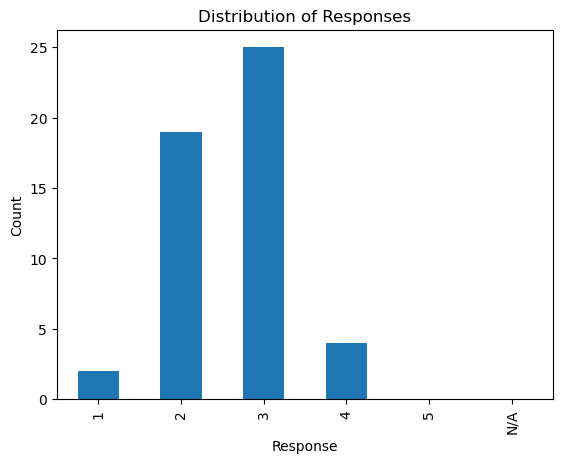

In [24]:

df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [25]:
# compute the average and std scores
average_score = df["response"].replace("N/A", pd.NA).astype(float).mean()
std_score = df["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score:.2f}")
print(f"Standard deviation of scores: {std_score:.2f}")

Average score: 2.62
Standard deviation of scores: 0.70


In [26]:
is_there_a_good_market(df)

Percentage of positive responses (4-5): 8.00%
Percentage of neutral responses (3): 50.00%
Percentage of negative responses (1-2): 42.00%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.62
Standard deviation of responses: 0.70
VERDICT: There is not a good market for bottled gazpacho.


False

We can also chat with the agents in an ad-hoc way, to get a more detailed understanding if needed.

In [27]:
from tinytroupe.ui import AgentChatJupyterWidget

# Create and display the enhanced chat widget
chat_interface = AgentChatJupyterWidget(people)
chat_interface.display()

In [28]:
#control.end()

## Empirical Data Validation
Now let's see how the above matches the same research done with actual real people!

In [29]:
control_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_csv(
            file_path="../data/empirical/07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv",
            experimental_data_type="single_value_per_agent",
            agent_id_column="Responder #",
            value_column="Vote",
            agent_comments_column="Explanation",
            agent_attributes_columns=["Age Range", "Gender Identity", "Political Affiliation", "Racial Or Ethnic Identity"],
            dataset_name="Test Gazpacho Survey"
        )

In [30]:
control_data

SimulationExperimentDataset(name='Test Gazpacho Survey', description='Empirical data loaded from 07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv', key_results={'Vote': [4, 1, 1, 5, 3, 4, 2, 4, 1, 1, 3, 2, 2, 5, 4, 3, 3, 5, 4, 2, 3, 5, 3, 3, 5, 1, 3, 4, 3, 1, 1, 4, 3, 3, 2, 1, 4, 3, 4, 2, 1, 1, 2, 1, 2, 5, 2, 4, 3, 5]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 5, 'num_ranks': 5, 'rank_values': [1, 2, 3, 4, 5], 'direction': 'ascending'}}, agent_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'], agent_justifications=[{'agent_name': '1', 'agent_index': 0, 'justification': 'Yes because it is something i have nev

<Axes: xlabel='0'>

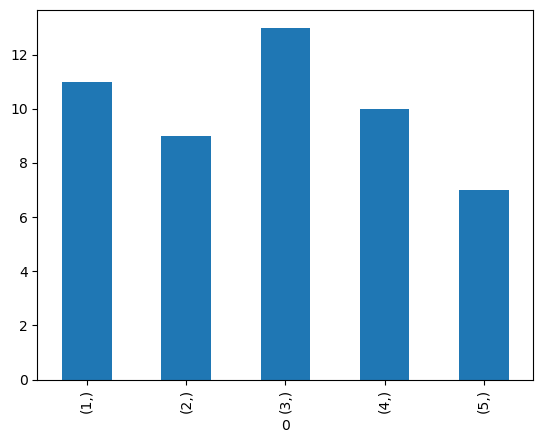

In [31]:
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind="bar")

In [32]:
# Convert string responses to numeric values and rename column to match control_data
df_for_validation = df.copy()
df_for_validation["Vote"] = pd.to_numeric(df_for_validation["response"], errors='coerce')

# Create treatment data with matching column name and data type
treatment_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_dataframe(
    df=df_for_validation,
    experimental_data_type="single_value_per_agent",
    agent_id_column="name",
    value_column="Vote",
    agent_comments_column="justification",
    dataset_name="Bottled Gazpacho Simulation Results"
)

In [33]:
treatment_data

SimulationExperimentDataset(name='Bottled Gazpacho Simulation Results', description='Empirical data loaded from pandas DataFrame', key_results={'Vote': [2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 4, 3, 1, 3, 2, 2, 3, 3, 3, 2, 2, 2, 4, 2, 2, 2, 3, 4, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 4, 3, 2, 1, 2, 3, 3, 3]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 4, 'num_ranks': 4, 'rank_values': [1, 2, 3, 4], 'direction': 'ascending'}}, agent_names=['Jamal Hernandez', 'Emily Chang-Bennett', 'Tanner Reid Olson', 'Arjun Kiran Patel', 'Caleb Nathaniel Reed', 'Casey Nguyen', 'Maria Elena Carter', 'Lauren Fitzgerald', 'Malachi James Redbird', 'Rebecca Anne Malone', 'Mariana Isabel Ramirez', 'Kathleen Marie Hawthorne', 'Jordan Park-Sullivan', 'James Patrick Ellison', 'Claire Donovan', 'Owen Parker Bennett', 'Erin Caroline Matthews', 'Camila Rodriguez', 'Dylan Marcus Anderson', 'Jalen Anton

In [34]:
result_ttest = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        output_format="values"
    )

In [35]:
result_ttest.overall_score

0.8178508126227093

In [36]:
result_ttest.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Welch t-test (unequal variance)',
    'control_mean': 2.86,
    'treatment_mean': 2.62,
    'mean_difference': -0.23999999999999977,
    'percent_change': -8.391608391608383,
    't_statistic': 1.1135844371980819,
    'p_value': 0.2691008725597071,
    'confidence_interval': (-0.6695115401306055, 0.18951154013060606),
    'confidence_level': 0.95,
    'significant': False,
    'degrees_of_freedom': 73.19933785889931,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.6966391622992348,
    'effect_size': -0.2227168874396164}}},
 'test_type': 'welch_t_test',
 'significance_level': 0.05}

In [37]:
result_ttest.semantic_results

In [38]:
result_ks = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        statistical_test_type="ks_test",
        output_format="values"
    )

In [39]:
result_ks.overall_score

0.7936507936507936

In [40]:
result_ks.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Kolmogorov-Smirnov test',
    'control_mean': 2.86,
    'treatment_mean': 2.62,
    'control_median': 3.0,
    'treatment_median': 3.0,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.6966391622992348,
    'ks_statistic': 0.26,
    'p_value': 0.06779471096995852,
    'significant': False,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'effect_size': 0.26,
    'overlap_coefficient': 0.3888888888888889,
    'percentile_differences': {'p25_diff': 0.0,
     'p50_diff': 0.0,
     'p75_diff': -1.0,
     'p90_diff': -2.0,
     'p95_diff': -1.0},
    'interpretation': 'No significant difference between distributions',
    'confidence_level': 0.95}}},
 'test_type': 'ks_test',
 'significance_level': 0.05}

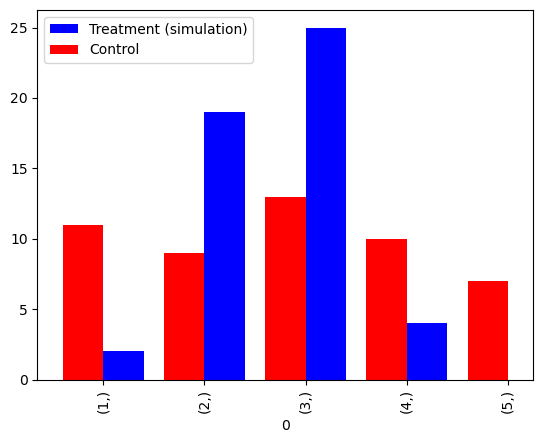

In [41]:
# compare charts. Put both bars in the same plot, for easier comparison
# Need to order the labels in the chart.
fig, ax = plt.subplots()
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar', color='blue', position=0, width=0.4, label="Treatment (simulation)", ax=ax)
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind='bar', color='red', position=1, width=0.4, label="Control", ax=ax)
plt.legend()
plt.show()

In [42]:
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"])

response
1       2.0
2      19.0
3      25.0
4       4.0
5       NaN
N/A     NaN
Name: count, dtype: float64